In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D
import seaborn as sns
import plotly.express as px
import pycountry_convert as pc
from pathlib import Path

# <span style="color: skyblue;">**Descrizione del dataframe**

<span style="color: orange;">*movies.csv*: oltre 940.000 voci

- `id` - id del film - funge da chiave esterna per le altre relazioni
- `name` - titolo
- `date` - data di uscita
- `tagline` - lo slogan sul poster
- `description` - un breve riassunto della trama
- `minute` - durata in minuti
- `rating` - punteggio ottenuto

---
<span style="color: orange;">*countries.csv*: oltre 693.000 voci

- `id` - id del film
- `country` - uno dei paesi di origine - può essercene più di uno per film, perciò possono esserci più entries per lo stesso _id_

---
<span style="color: orange;">*actors.csv*: oltre 5,7 milioni di voci

- `id` - id del film
- `name` - nome dell'attore/attrice
- `role` - personaggio interpretato

---
<span style="color: orange;">*crew.csv*: oltre 4,7 milioni di voci

- `id` - id del film
- `role` - ruolo intrapreso nella crew (ad esempio regista, fonico, ...)
- `name` - nome della persona

---
<span style="color: orange;">*posters.csv*: oltre 940.000 voci

- `id` - id del film
- `link` - url ai poster originali dei film - può essercene più di uno per film, perciò possono esserci più entries per lo stesso _id_

---
<span style="color: orange;">*releases.csv*: oltre 13 milioni di voci

- `id` - id del film
- `country` - Paese di rilascio
- `date` - data di rilascio - un film può essere rilasciato in Paesi diversi in date diverse
- `type` - formato di rilascio (cinematografico, digitale, ...) - un film può essere rilasciato in formati diversi in momenti diversi e Paesi diversi
- `rating` - valutazione ricevuta nel paese di rilascio e per quel formato

---
<span style="color: orange;">*the_oscar_awards.csv*: oltre 10.000 voci

- `year_film` - l'anno in cui è uscito il film
- `year_ceremony` - l'anno della cerimonia degli Oscar
- `category` - categoria della candidatura (ad esempio 'Miglior attore protagonista')
- `name` - nome della persona candidata (che sia attore, regista, ...)
- `film` - il titolo del film candidato
- `winner` - indica se ha vinto o meno la candidatura

---
<span style="color: orange;">*rotten_tomatoes_reviews.csv*: oltre 1,1 milioni di recensioni da Rotten Tomato

- `rotten_tomatoes_link` - url alla recensione, da aggiungere a [https://www.rottentomatoes.com/](https://www.rottentomatoes.com/)
- `movie_title` - titolo del film a cui è riferita la recensione
- `critic_name` - nickname del critico
- `top_critic` - appartiene ai critici [approvati da Rotten Tomatoes](https://www.rottentomatoes.com/critics/top_critics)
- `publisher_name` - piattaforma editoriale che ha originariamente pubblicato la recensione
- `review_type` - classificazione binaria "Fresh" (positiva) o "Rotten" (negativa)
- `review_score` - punteggio originale del critico (il formato varia da testata a testata)
- `review_date` - data in cui è stata pubblicata la recensione
- `review_content` - contenuto testuale della recensione

### <span style="color: skyblue;"> Settaggio parametri grafici

In [15]:
from utils import get_pastel_palette_light

from utils import graphic_settings
graphic_settings(plt)

# <span style="color: skyblue;"> Caricamento del dataset

I dataset vengono salvati in un dizionario. Le keys corrispondono ai nomi dei file.

In [3]:
folder_df = Path("../../data")

In [4]:
df={}
for dataset in folder_df.iterdir():
    df[dataset.name.replace('.csv', '')] = pd.read_csv(dataset)

# <span style="color: skyblue;"> **Data cleaning**

### <span style="color: orange;"> *Standardizzazione dei Nomi delle Colonne*

Rendiamo omogenei i nomi delle colonne (snake_case, rimozione spazi, uniformazione di acronimi). Questo semplifica le join e riduce errori dovuti a varianti nominali.

In [5]:
df['movies'] = df['movies'].rename(columns={'name' : 'movie_title', 'date' : 'movie_year', 'rating' : 'movie_rating'})

In [6]:
df['actors'] = df['actors'].rename(columns={'name' : 'actor_name'})

In [7]:
df['the_oscar_awards'] = df['the_oscar_awards'].rename(columns={'name' : 'member_name', 'film' : 'movie_title', 'year_film': 'movie_year'})

In [8]:
df['releases'] = df['releases'].rename(columns={'country' : 'release_country', 'date' : 'release_date', 'type' : 'release_type', 'rating' : 'release_rating'})

In [9]:
df['crew'] = df['crew'].rename(columns={'name' : 'crew_name'})

In [10]:
df['languages'] = df['languages'].rename(columns={'type' : 'language_type'})

### <span style="color: orange;"> *Identificazione dei duplicati*

Per ogni dataframe:
1. Normalizza i campi di testo (rimuove spazi e converte in minuscolo)
2. Identifica le righe duplicate e aggiunge una colonna booleana `is_duplicate`

Il dataset *movies* necessita di un approccio diverso:
   considera duplicati solo in base alla combinazione di titolo e anno.
   Questo risulta necessario in quanto, con una rapida esplorazione del dataset, si è visto che esistono film con lo stesso titolo ma rilasciati in anni differenti (ad esempio, per il titolo *Barbie* esiste una versione del 2023 e una versione del 2012, ma sono film differenti).

In [ ]:
for k in [x for x in df.keys() if x != 'movies']:
    if 'is_duplicate' in df[k].columns:
        df[k].drop('is_duplicate', axis=1, inplace=True)

    tmp = df[k].apply(lambda x : x.str.strip().str.lower() if x.dtype == 'object' else x)
    duplicate = tmp.duplicated()
    # i True vengono trattati come 1
    print(k, duplicate.sum())
    df[k]['is_duplicate'] = duplicate

tmp = df['movies'].apply(lambda x : x.str.strip().str.lower() if x.dtype == 'object' else x)
duplicate = tmp.duplicated(subset=['movie_title','movie_year'])

df['movies']['is_duplicate'] = duplicate

actors 961
countries 0
crew 1288
genres 0
languages 0
posters 0
releases 0
rotten_tomatoes_reviews 119471
studios 230
themes 0
the_oscar_awards 7


Mostriamo tramite un bar chart la percentuale di duplicati trovati per ogni dataframe.

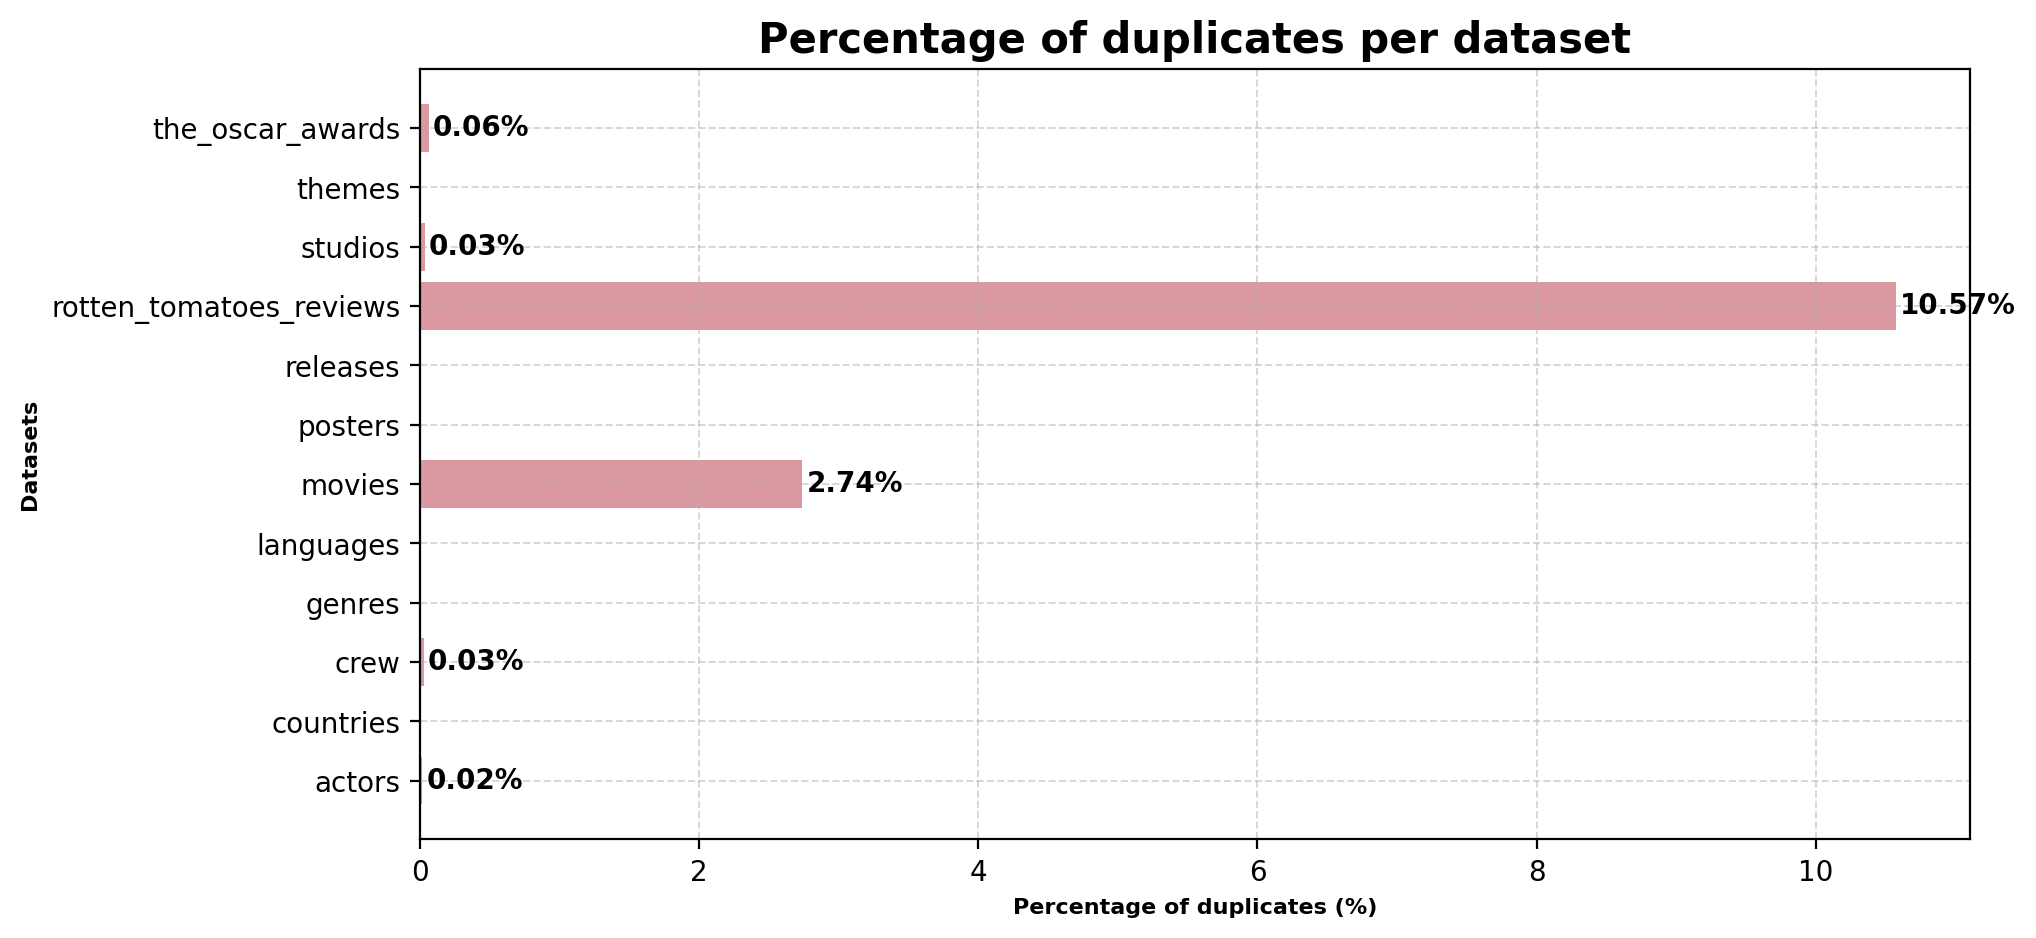

In [16]:
pal = list(get_pastel_palette_light(n=24))

plt.figure(figsize=(10,5))
for k in df.keys():
    perc =  (len(df[k][df[k]['is_duplicate']==True]) / len(df[k]))*100
    plt.barh(k, perc, color=pal[0])
    if perc != 0:
        plt.text(perc + 0.03 , k, f'{perc:.2f}%', va='center', ha='left', fontsize=10, fontweight='bold')
plt.title('Percentage of duplicates per dataset', fontweight='bold', fontsize=15)
plt.xlabel('Percentage of duplicates (%)')
plt.ylabel('Datasets')
plt.show()

Prima di rimuovere i duplicati, puliamo ulteriormente i df eliminando le entries contenenti stringhe di un formato non consono e, dove richiesto, convertiamo il formato delle date.La presenza significativa di duplicati (specialmente nelle recensioni di Rotten Tomatoes) suggerisce la necessità di una fase di pulizia dei dati prima di procedere con analisi più approfondite.

### <span style="color: orange;"> Standardizzazione dei campi testuali

Questa sezione implementa una pulizia approfondita dei campi testuali nel dataset *movies*. Le operazioni eseguite sono:

- Rimozione di caratteri Unicode invisibili (BOM e zero-width space)
- Eliminazione di newline, carriage return e tab
- Normalizzazione degli spazi multipli in spazio singolo
- Rimozione degli spazi bianchi iniziali e finali

In [17]:
text_columns = ["movie_title", "tagline", "description"]

for column in text_columns:
    df['movies'][column] = (
        df['movies'][column]
            .str.replace(r'[\uFEFF\u200B]', '', regex=True)
            .str.replace(r'[\n\r\t]', '', regex=True)
            .str.replace(r'\s+', ' ', regex=True)
            .str.strip()
    )

Il dataset *releases* richiede anche la conversione della colonna `release_date` da stringa in formato datetime di pandas.
I vantaggi includono:
- Possibilità di effettuare calcoli temporali
- Facilitare il filtraggio e l'ordinamento per data

In [18]:
df['releases']['release_date'] = pd.to_datetime(df['releases']['release_date'], format="%Y-%m-%d")

Possiamo ora procedere ad eliminare i duplicati, filtrando per tutti i valori di `drop_duplicates` che sono `False`.

In [19]:
df_clean={}
for k,v in df.items():
    df_clean[k] = v[v['is_duplicate'] == False].drop('is_duplicate', axis=1)

### <span style="color: orange;"> *Armonizzazione degli Identificatori*

La normalizzazione delle chiavi primarie viene effettuata assumendo il dataset *movies* come riferimento principale.

Un'analisi preliminare evidenzia discrepanze tra gli identificatori presenti nei vari dataframe rispetto a quelli del dataset *movies*.

In [20]:
# controllo discrepanze
movies = df_clean['movies']
template_id = df_clean['movies']['id'].unique()

for k in df_clean.keys():
    if k == 'movies' or k == 'rotten_tomatoes_reviews' or k == 'the_oscar_awards':
        continue
    print(k, len(template_id)-len(df_clean[k]['id'].unique()), sep="\t")

actors	281493
countries	298603
crew	108733
genres	239304
languages	10217
posters	-25802
releases	89777
studios	477598
themes	891287


Come si può notare, per tutti abbiamo discrepanza.

Si procede ad uniformare la presenza degli ID come segue:
- si ottengono gli id univoci di movies;
- si generano nuovi dataframe soltanto con gli id presenti in movies facendo un left join con gli altri dataframe;
- non vengono considerati gli id non presenti in movies ma presenti negli altri dataset.

In [21]:
# assegnazione di un nuovo dizionario uniformato.
unique_id = len(movies['id'].unique())

df_finale= {}
for k in df_clean.keys():
    if k == 'movies' or k == 'rotten_tomatoes_reviews' or k == 'the_oscar_awards':
        df_finale[k] = df_clean[k]
        continue
    temp= pd.merge(movies, df_clean[k], on='id', how='left')[df_clean[k].columns]
    if len(temp['id'].unique()) != unique_id:
        print(f'PROBLEMI CON IL DATASET {k}')
        break
    df_finale[k] = temp

### <span style="color: orange;"> *Uniformare le valutazioni degli utenti sul dataset 'rotten_tomatoes_reviews'*

C'è bisogno di uniformare il campo `review_score` degli iscritti per il dataset *rotten_tomatoes_reviews*.
Per questo abbiamo bisogno di vedere quanta diversità di formato abbiamo e scegliere una scala comune.

Le dividiamo in 4 categorie:
- alfabetiche
- x/5
- x/10
- x/100

Per adesso convertiamo tutto in una scala che vada da 1 a 10.

Per procedere, utilizziamo la funzione `converter`.


In [23]:
from utils import converter 

review_pre_convert= df_finale['rotten_tomatoes_reviews']['review_score']
df_finale['rotten_tomatoes_reviews']['review_score'] = df_finale['rotten_tomatoes_reviews']['review_score'].map(converter)

**Quante reviews ci siamo persi facendo la conversione?**

In [24]:
new_nan_records = (df_finale['rotten_tomatoes_reviews']['review_score'].isna() & ~review_pre_convert.isna()).sum()
print(f'Percentuale di reviews perse: {round(new_nan_records/len(review_pre_convert.isna())*100,2)}%')

Percentuale di reviews perse: 0.14%


# <span style="color: skyblue;"> **Data Analysis**

### <span style="color: orange;">*Distribuzione del numero di film prodotti per anno*

In [25]:
df_finale['movies']

,id,movie_title,movie_year,tagline,description,minute,movie_rating
0,1000001,Barbie,2023.0,She's everything. He's just Ken.,Barbie and Ken are having the time of their li...,114.0,3.86
1,1000002,Parasite,2019.0,Act like you own the place.,"All unemployed, Ki-taek's family takes peculia...",133.0,4.56
2,1000003,Everything Everywhere All at Once,2022.0,The universe is so much bigger than you realize.,An aging Chinese immigrant is swept up in an i...,140.0,4.30
3,1000004,Fight Club,1999.0,Mischief. Mayhem. Soap.,A ticking-time-bomb insomniac and a slippery s...,139.0,4.27
4,1000005,La La Land,2016.0,Here's to the fools who dream.,"Mia, an aspiring actress, serves lattes to mov...",129.0,4.09
...,...,...,...,...,...,...,...
941592,1941593,神笛,NaN,NaN,NaN,NaN,NaN
941593,1941594,蟲極道蜜団子抗争編 壱ノ巻,NaN,NaN,Shinjuku forest at night. In the sap taverns o...,30.0,NaN
941594,1941595,蟲極道蜜団子抗争編 弐ノ巻,NaN,NaN,"The city that never sleeps, where insects gath...",30.0,NaN
941595,1941596,重生,NaN,NaN,"In a world where order has broken down, darkne...",NaN,NaN


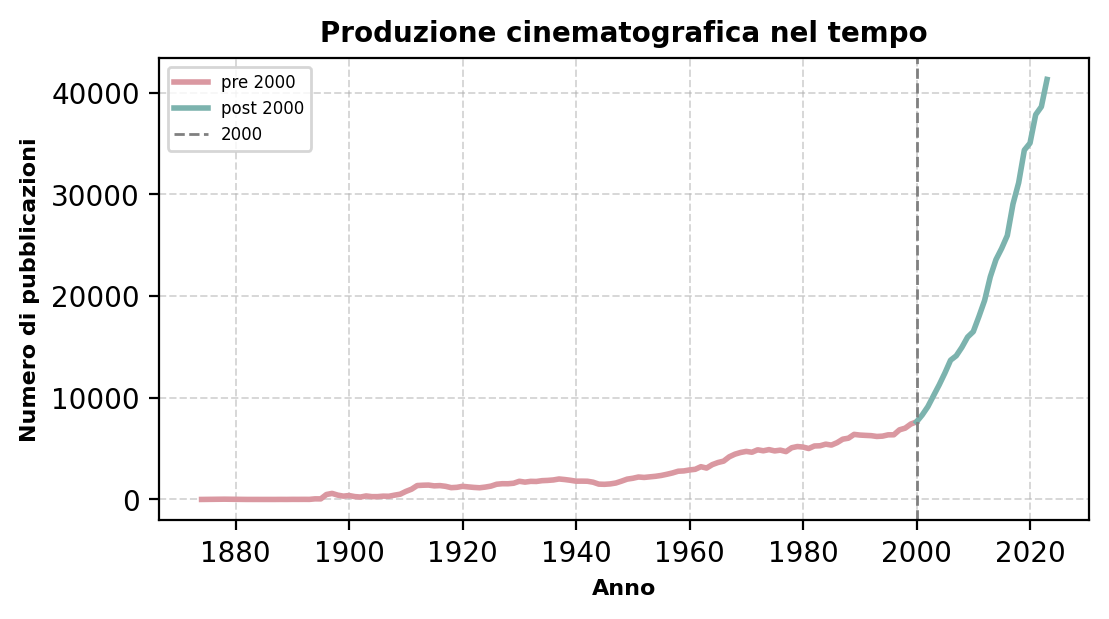

In [26]:
group_date = df_finale['movies'].groupby('movie_year')['id'].count()

pal = get_pastel_palette_light(n=12)

group_date_1 = group_date[group_date.index <= 2000]
group_date_2 = group_date[(group_date.index >= 2000) & (group_date.index < 2024)]
plt.plot(group_date_1, label='pre 2000', color=pal[0])
plt.plot(group_date_2, label='post 2000', color=pal[6])
plt.axvline(x=2000, color='grey', linestyle='--', label='2000', alpha=1, linewidth=1)
plt.legend()
plt.title('Produzione cinematografica nel tempo')
plt.xlabel('Anno')
plt.ylabel('Numero di pubblicazioni')
plt.show()

Il grafico rivela un vertiginoso aumento della produzione dopo il 2000. Questo fenomeno rappresenta il risultato della rivoluzione digitale che ha trasformato radicalmente il settore cinematografico.

Tra i principali fattori che spiegano tale crescità c'è sicuramente una riduzione drastica dei costi delle apparecchiature digitali e la possibilità di girare film anche con doispositivi non professionali.

Si può notare anche il minimo del 2020, probabilmente legato alla pandemia, con rimbalzo parziale nel 2021–2022.

Accanto alla quantità, indaghiamo la struttura: la durata.
##### **La crescita (o contrazione) della produzione ha cambiato il formato dei film?**
Esploriamo ora come si distribuisce il metraggio e se è variato per epoca.

### <span style="color: orange;"> *Classificazione dei Film per Durata*

#### <span style="color: orange;"> *Categorizzazione dei Film per Metraggio* 

Definiamo:
- **Cortometraggio**: film con una durata inferiore a 30 minuti (secondo l'Academy Awards) o 40 minuti (secondo il Festival di Cannes e altre istituzioni).
- **Mediometraggio**: film con una durata compresa tra 30/40 minuti e 60 minuti. È una categoria meno utilizzata rispetto alle altre due.
- **Lungometraggio**: film con una durata superiore a 60 minuti (spesso 70-90 minuti in su, per essere considerato standard nelle sale cinematografiche).
- **Altro**: i non film, spesso serie TV, tutti quei record che hanno un minutaggio maggiorre di 4 ore.


Analizziamo prima la distribuzione per minutaggio.

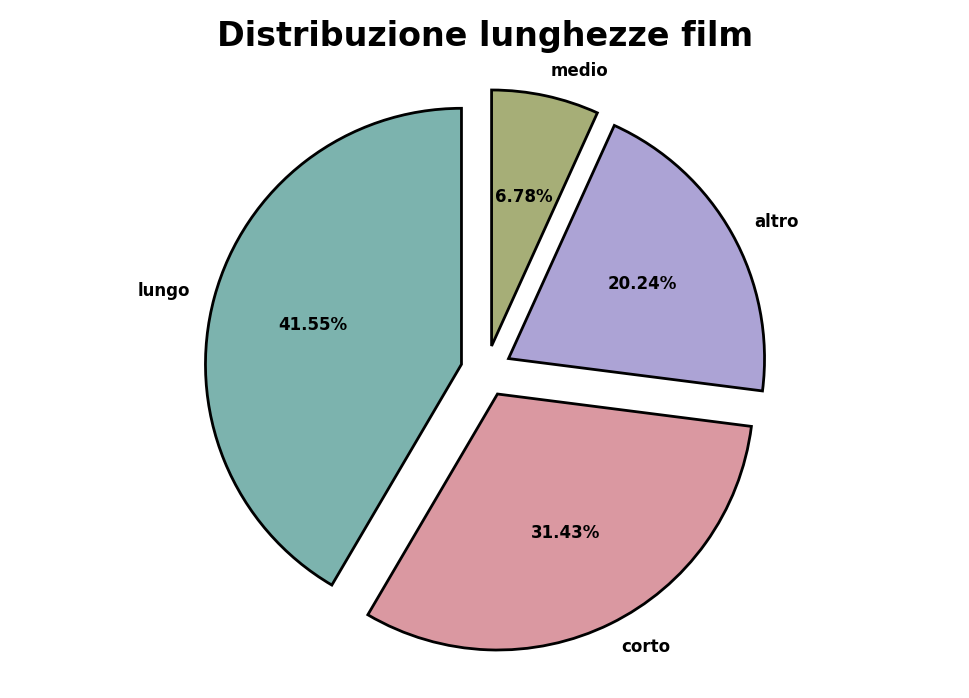

In [27]:
from utils import categorize_movie

df_finale['movies']['categoria'] = df_finale['movies'].apply(categorize_movie, axis=1)

counts = df_finale['movies']['categoria'].value_counts(dropna=False)
perc = (counts / counts.sum() * 100).round(2)

ordered_cats = ['corto', 'medio', 'lungo', 'altro']
pal = get_pastel_palette_light(n=len(ordered_cats))
color_map = dict(zip(ordered_cats, pal))

labels = perc.index
sizes = perc.values
explode = [0.1] * len(perc)
colors = [color_map.get(lbl, pal[0]) for lbl in labels]

graphic_settings(plt)
plt.figure(figsize=(6,4))
plt.pie(
    sizes,
    labels=labels,
    colors=colors,
    autopct='%1.2f%%',
    startangle=90,
    wedgeprops={'edgecolor': 'black'},
    textprops={'fontsize': 6, 'fontweight': 'bold'},
    radius=1,
    explode=explode,
    shadow=False
)
plt.title('Distribuzione lunghezze film', fontweight='bold', fontsize=12)
plt.gca().axis('equal')
plt.show()

Un'analisi preliminare visiva suggerisce che i lungometraggi (41.55%) dominano il mercato, rappresentando il cinema tradizionale commerciale, mentre l'alta percentuale dei cortometraggi (31.43%) testimonia la vitalità della produzione sperimentale e indipendente.

È importante sottolineare che una significativa porzione della categoria *altro* nel nostro dataset corrisponde a contenuti televisivi seriali e non convenzionali.

Procedendo con un'analisi temporale comparativa tra le diverse categorie di contenuto, ci aspettiamo una crescita significativa della categoria *altro* a partire dagli anni '90 e 2000, con un'accelerazione importante e un trend monotono crescente.
Tale dinamica è verosimilmente trainata dalla digitalizzazione dei processi produttivi, dall’emersione di formati ibridi e promozionali, dall’espansione dei canali extra‑teatrali (home video, web, poi streaming) e dalla maggiore serializzazione di contenuti brevi.

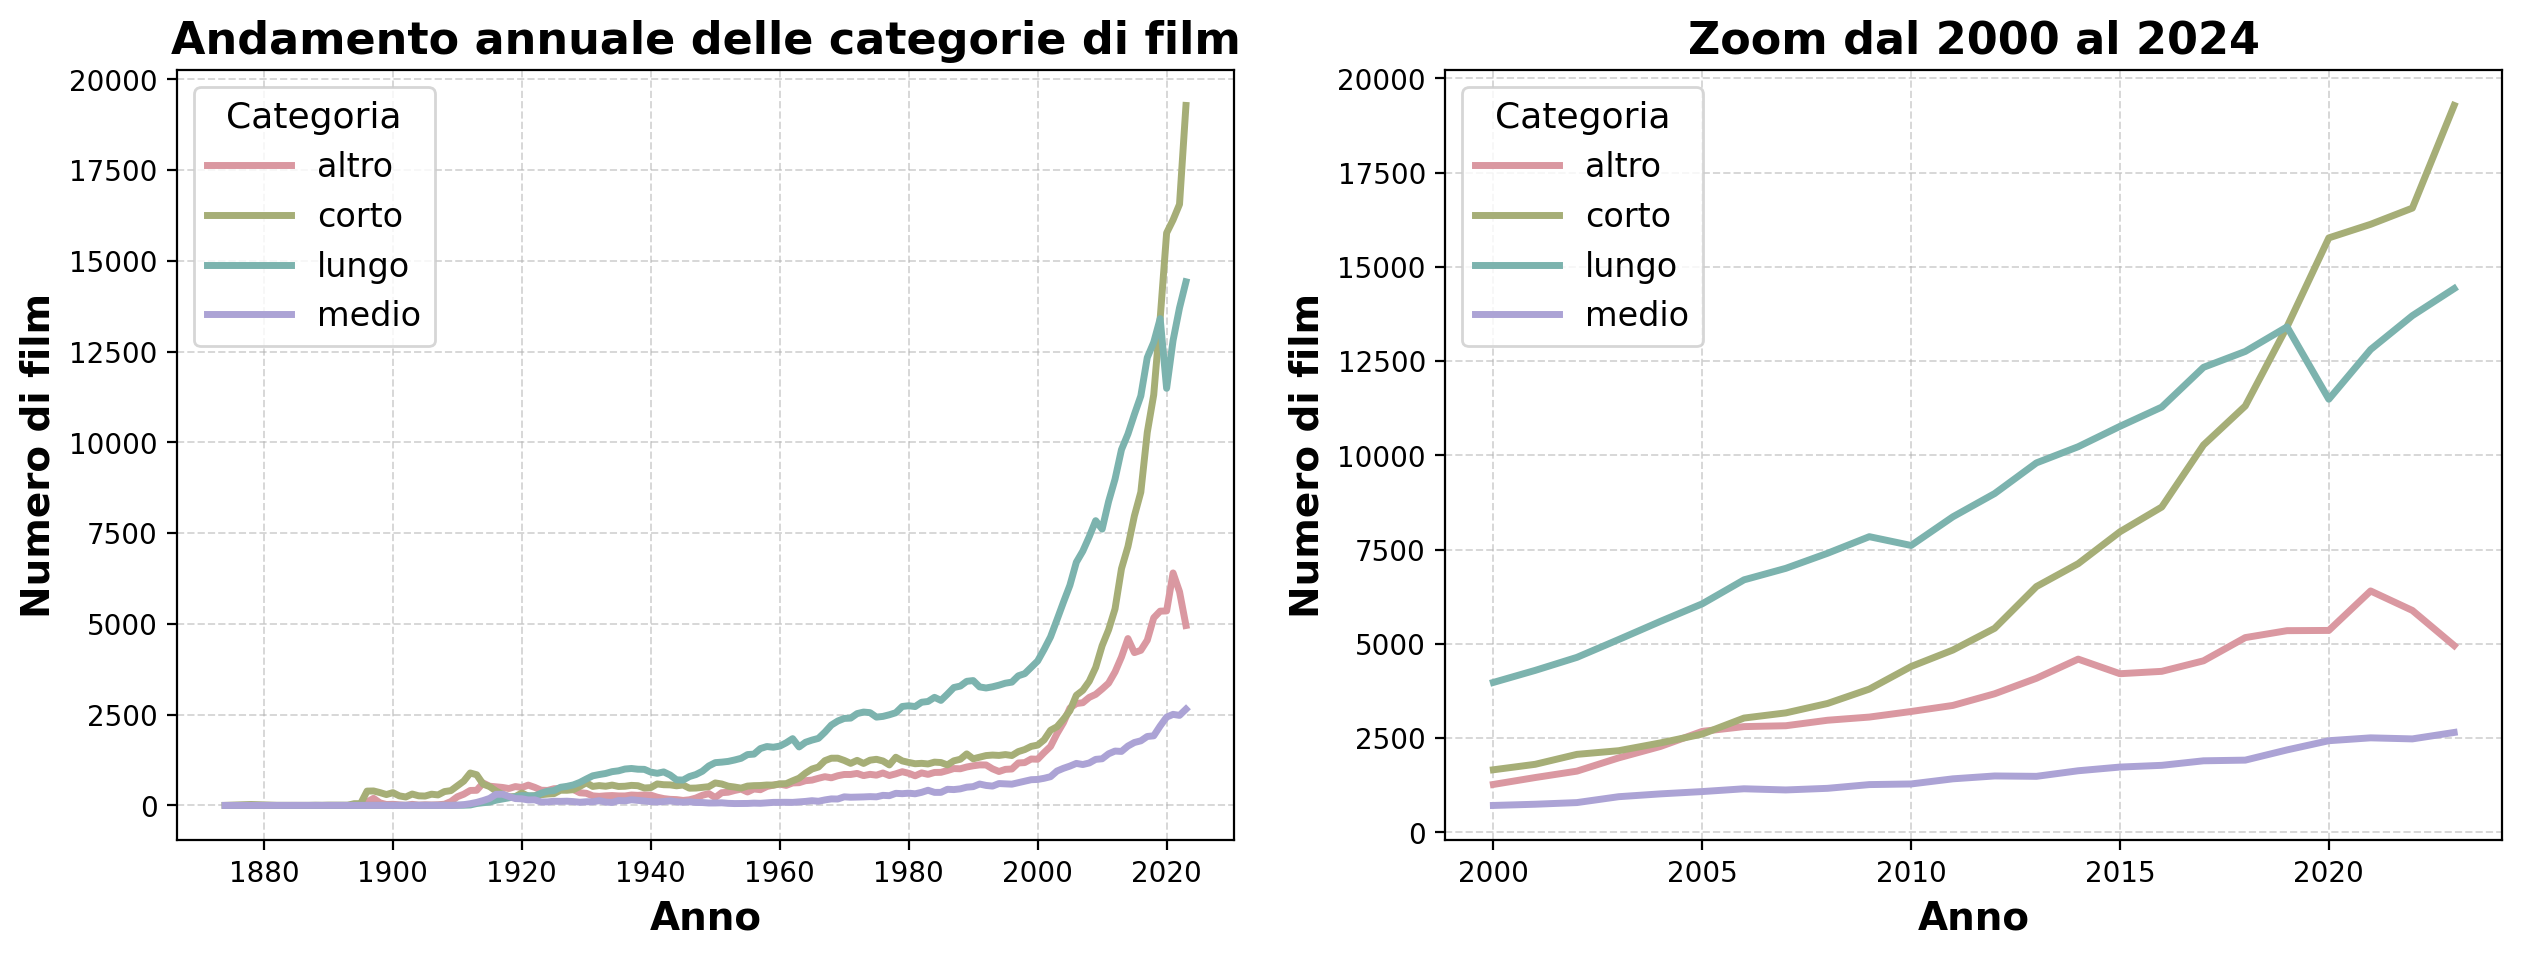

In [52]:
a = df_finale['movies'][df_finale['movies']['movie_year'] < 2024].groupby(['movie_year', 'categoria']).size().reset_index(name='count')

a = a.pivot(index='movie_year', columns='categoria', values='count').fillna(0)

pal = get_pastel_palette_light(n=4)

fig, ax = plt.subplots(1, 2, figsize=(15,5))

for i, categoria in enumerate(a.columns):
    ax[0].plot(a.index, a[categoria], label=categoria, color=pal[i], linewidth=2.5)

ax[0].set_xlabel('Anno', fontsize=14)
ax[0].set_ylabel('Numero di film', fontsize=14)
ax[0].set_title('Andamento annuale delle categorie di film', fontsize=16)
ax[0].legend(title='Categoria', fontsize=12, title_fontsize=13, markerscale=1.5, handlelength=2.5)
ax[0].grid(True)


a_zoom = a.loc[2000:2024]
for i, categoria in enumerate(a_zoom.columns):
    ax[1].plot(a_zoom.index, a_zoom[categoria], label=categoria, color=pal[i], linewidth=2.5)

ax[1].set_xlabel('Anno', fontsize=14)
ax[1].set_ylabel('Numero di film', fontsize=14)
ax[1].set_title('Zoom dal 2000 al 2024', fontsize=16)
ax[1].legend(title='Categoria', fontsize=12, title_fontsize=13, markerscale=1.5, handlelength=2.5)
ax[1].grid(True)

plt.show()

Utilizzando il concetto matematico della derivata, è possibile identificare i tassi di cambiamento nella produzione di film per ogni categoria, permettendo di rilevare punti di svolta significativi nel settore.

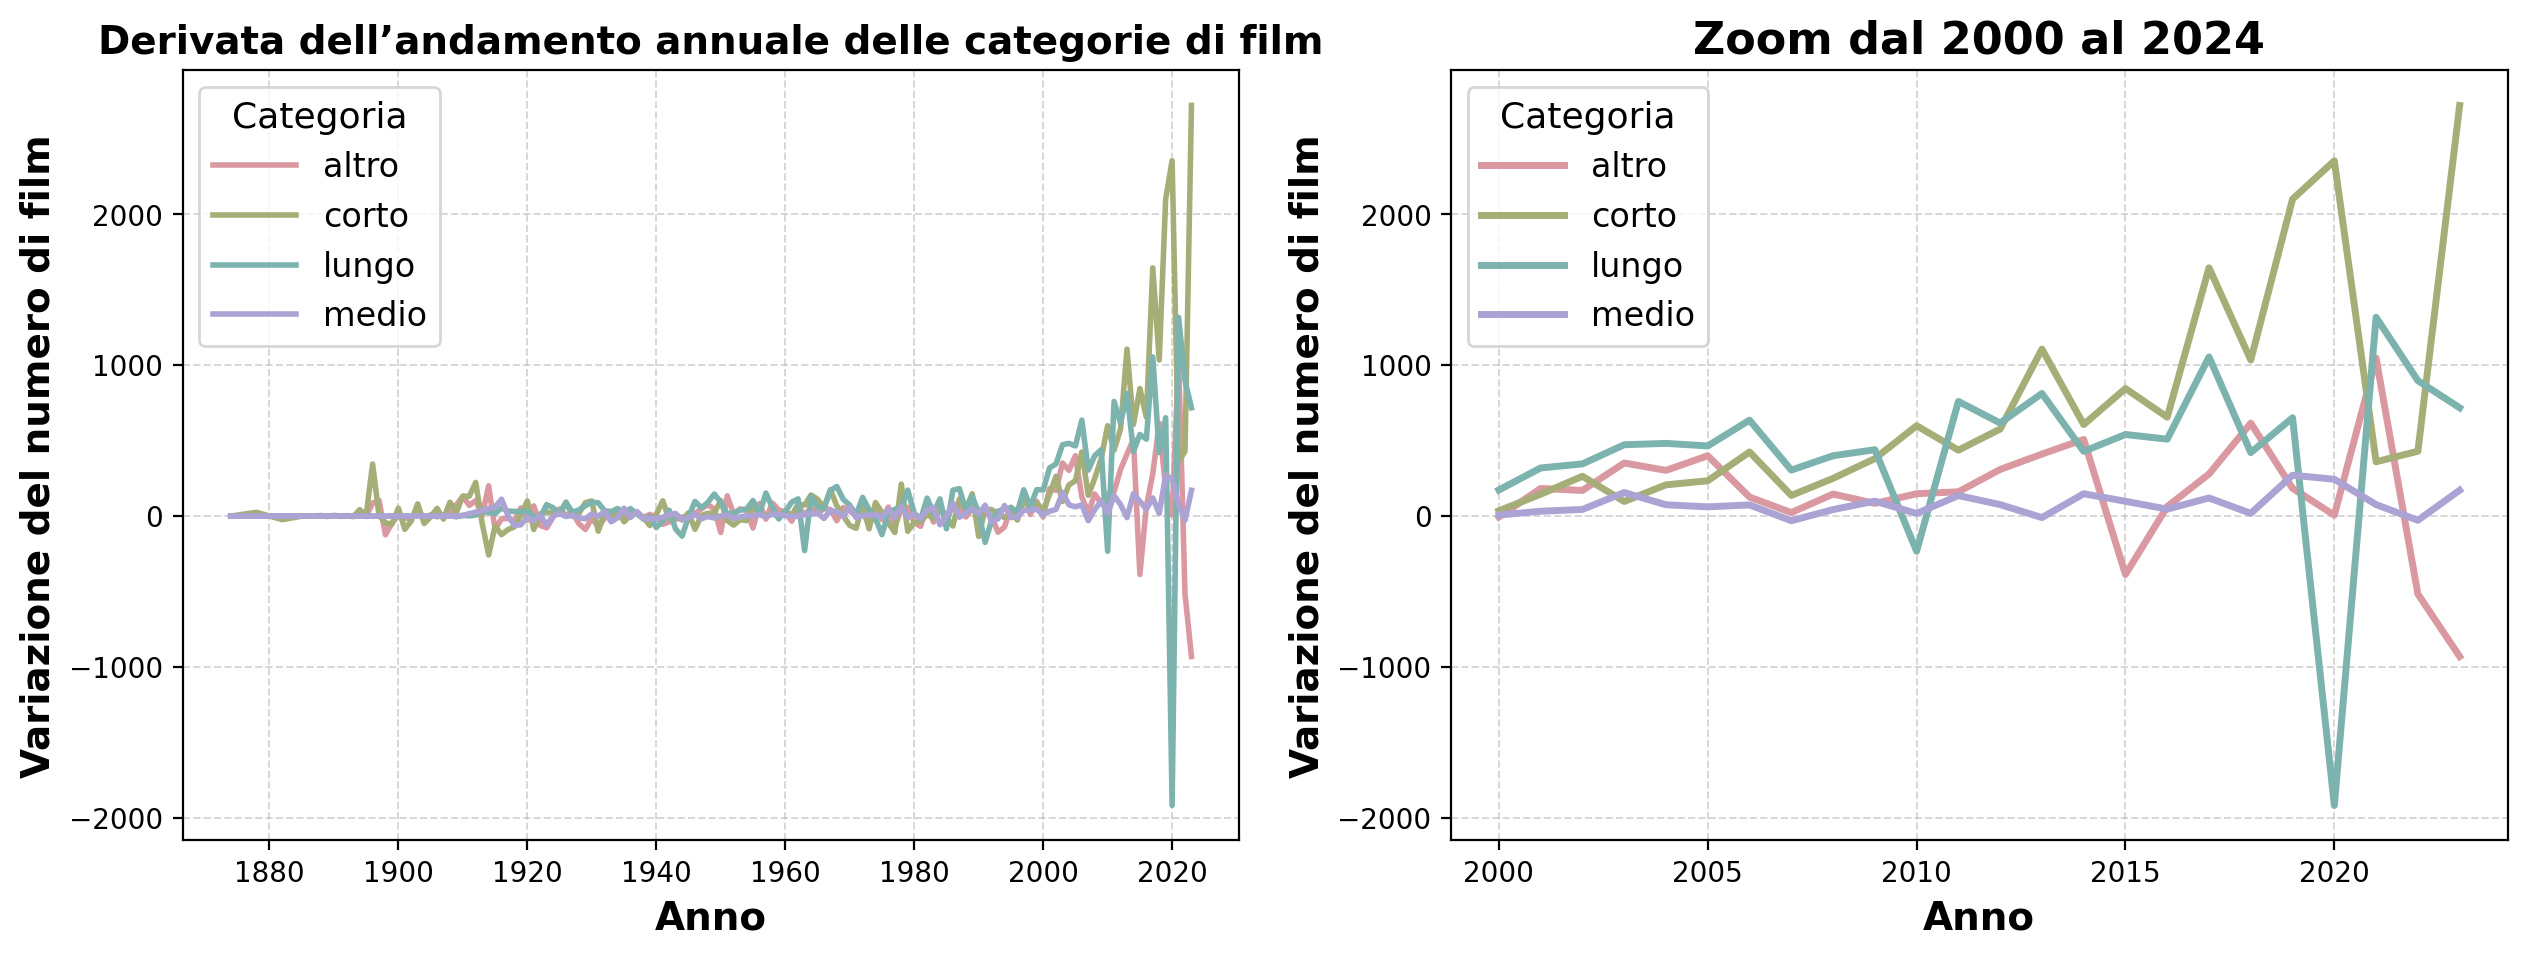

<Figure size 2400x1200 with 0 Axes>

In [53]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))

df_derivative = a.diff().fillna(0)  # Differenza rispetto all'anno precedente

plt.figure(figsize=(12, 6))
for i, categoria in enumerate(df_derivative.columns):
    ax[0].plot(df_derivative.index, df_derivative[categoria], label=categoria, color=pal[i])

ax[0].set_xlabel('Anno', fontsize=14)
ax[0].set_ylabel('Variazione del numero di film', fontsize=14)
ax[0].set_title('Derivata dell’andamento annuale delle categorie di film', fontsize=14)
ax[0].legend(title='Categoria', fontsize=12, title_fontsize=13, markerscale=1.5, handlelength=2.5)
ax[0].grid(True)


derivata_zoom = df_derivative.loc[2000:2024]
for i, categoria in enumerate(derivata_zoom.columns):
    ax[1].plot(derivata_zoom.index, derivata_zoom[categoria], label=categoria, color=pal[i], linewidth=2.5)

ax[1].set_xlabel('Anno', fontsize=14)
ax[1].set_ylabel('Variazione del numero di film', fontsize=14)
ax[1].set_title('Zoom dal 2000 al 2024', fontsize=16)
ax[1].legend(title='Categoria', fontsize=12, title_fontsize=13, markerscale=1.5, handlelength=2.5)
ax[1].grid(True)

plt.show()

Come possiamo vedere, la maggior parte della serie storica, fino a circa il 2000, mostra oscillazioni relativamente contenute per tutte le categorie, con variazioni riconducibili a normali ciclicità del settore e a fattori culturali. 

A partire dai primi anni 2000, il profilo diventa più dinamico: aumentano sia l’ampiezza sia la frequenza delle variazioni, in particolare per le categorie “corto” e “altro”, coerentemente con la progressiva digitalizzazione dei processi produttivi e la diffusione di canali extra‑teatrali. Nel complesso, l’andamento suggerisce una crescita tendenziale dei volumi accompagnata da una diversificazione dei formati.

####  <span style="color: orange;">Impatto della Pandemia COVID-19
Il 2020 rappresenta un punto di particolare interesse, mostrando un calo drammatico nella produzione e un minimo locale evidente. La contrazione è particolarmente marcata nella categoria "*lungo*" (lungometraggi).

La ragione è presumibilmente imputabile alla pandemia di COVID-19, che ha comportato diversi fattori:
- Chiusura delle sale cinematografiche e restrizioni alla distribuzione tradizionale;
- Interruzione/sospensione dei set e rallentamenti nelle post-produzioni;
- Vincoli sanitari che hanno ridotto la scala e la velocità dei progetti;
- Ridistribuzione degli investimenti verso piattaforme digitali.

Interessante la maggiore resilienza delle categorie “corto” e “altro”, che registrano una contrazione più contenuta e, in alcuni casi, un recupero più rapido nel 2021–2022. La spiegazione plausibile include:
- Costi e tempi di produzione inferiori, con team più piccoli e set più flessibili;
- Maggiore adattabilità a modalità di lavoro da remoto o in spazi controllati;
- Domanda in crescita di contenuti brevi/ibridi per piattaforme online;
- Minore dipendenza dalle uscite in sala e dai festival dal vivo.

####  <span style="color: orange;">Ripresa post‑2020 per categoria

Nel biennio successivo al 2020 si osserva un recupero: le categorie _corto_ e _altro_ tornano più rapidamente ai livelli pre‑shock, mentre i lungometraggi restano sotto trend, richiedendo tempi più lunghi per adattarsi.

È in questo contesto che si comprende meglio il ruolo delle principali case di produzione.

### <span style="color: orange;"> *Chi riparte davvero: case di produzione prima e dopo lo shock, e le traiettorie nel tempo*

Dopo lo shock pandemico la ripartenza non è uniforme. In questa sezione analizziamo i gruppi canonici globali come definiti da `canonical_global_group`, aggregando sussidiarie e alias sotto il relativo gruppo.

I gruppi includono:
- Major USA (Walt Disney Studios, Warner Bros. Pictures, Universal Pictures, Paramount Pictures, Sony Pictures Entertainment, Lionsgate)
- Giappone (Toho, Toei, Shochiku, Kadokawa, Nikkatsu, Studio Ghibli)
- Europa (StudioCanal/Canal+, Pathé, Gaumont, Constantin Film, UFA, Rai Cinema, Medusa, Working Title, BBC Films, Film4, Eon Productions)
- Cina/Corea/Hong Kong (China Film Group, Huayi Brothers, Bona, Enlight, Wanda; CJ ENM, Showbox, Lotte; Golden Harvest, Shaw Brothers)
- Altri mercati (Entertainment One, Village Roadshow, SF Studios, Nordisk Film, Telecinco Cinema, El Deseo, Filmax)

Mostriamo due grafici:
- _Slopegraph_ (prima vs dopo): confronta la posizione relativa dei major tra il periodo antecedente allo shock (2000–2019) e la fase di ripresa (2021–2024), evidenziando chi avanza o arretra.

- _Bump chart_ (traiettorie nel tempo): segue anno per anno le posizioni dei major, mettendo in evidenza continuità, sorpassi e rientri.

La lettura congiunta mostra non solo variazioni nell’intensità produttiva, ma anche differenze nella capacità di adattamento post‑2020 da parte dei principali gruppi.

In [30]:
movies_studios = pd.merge(df_finale['movies'], df_finale['studios'], on='id', how='inner')

from utils import canonical_global_group

ms = movies_studios.copy()
ms['group'] = ms['studio'].apply(canonical_global_group)

# concentriamoci solo sulle major
maj = ms[~ms['group'].isna()].copy()

min_year, max_year = 2000, 2024
pre  = maj[(maj['movie_year']>=min_year) & (maj['movie_year']<=2019)]
post = maj[(maj['movie_year']>=2021) & (maj['movie_year']<=max_year)]

pre_share  = (pre.groupby('group').size()/len(pre)).rename('pre')
post_share = (post.groupby('group').size()/len(post)).rename('post')
shares = pd.concat([pre_share, post_share], axis=1).fillna(0)

studios = shares.nlargest(10, 'post').index.tolist()

# slopegraph a ranghi
pre_counts  = pre.groupby('group').size()
post_counts = post.groupby('group').size()
pre_rank    = pre_counts.rank(ascending=False, method='first').reindex(studios)
post_rank   = post_counts.rank(ascending=False, method='first').reindex(studios)

# bump: ranking annuale per i soli studi selezionati
yearly = (maj.groupby(['movie_year','group'])
          .size().rename('count').reset_index())

yr = yearly[
    yearly['movie_year'].between(min_year, max_year) &
    yearly['group'].isin(studios)
]

ranks = (yr.assign(rank=yr.groupby('movie_year')['count']
                   .rank(ascending=False, method='first'))
           .pivot(index='movie_year', columns='group', values='rank')
           .reindex(columns=studios)
           .sort_index())


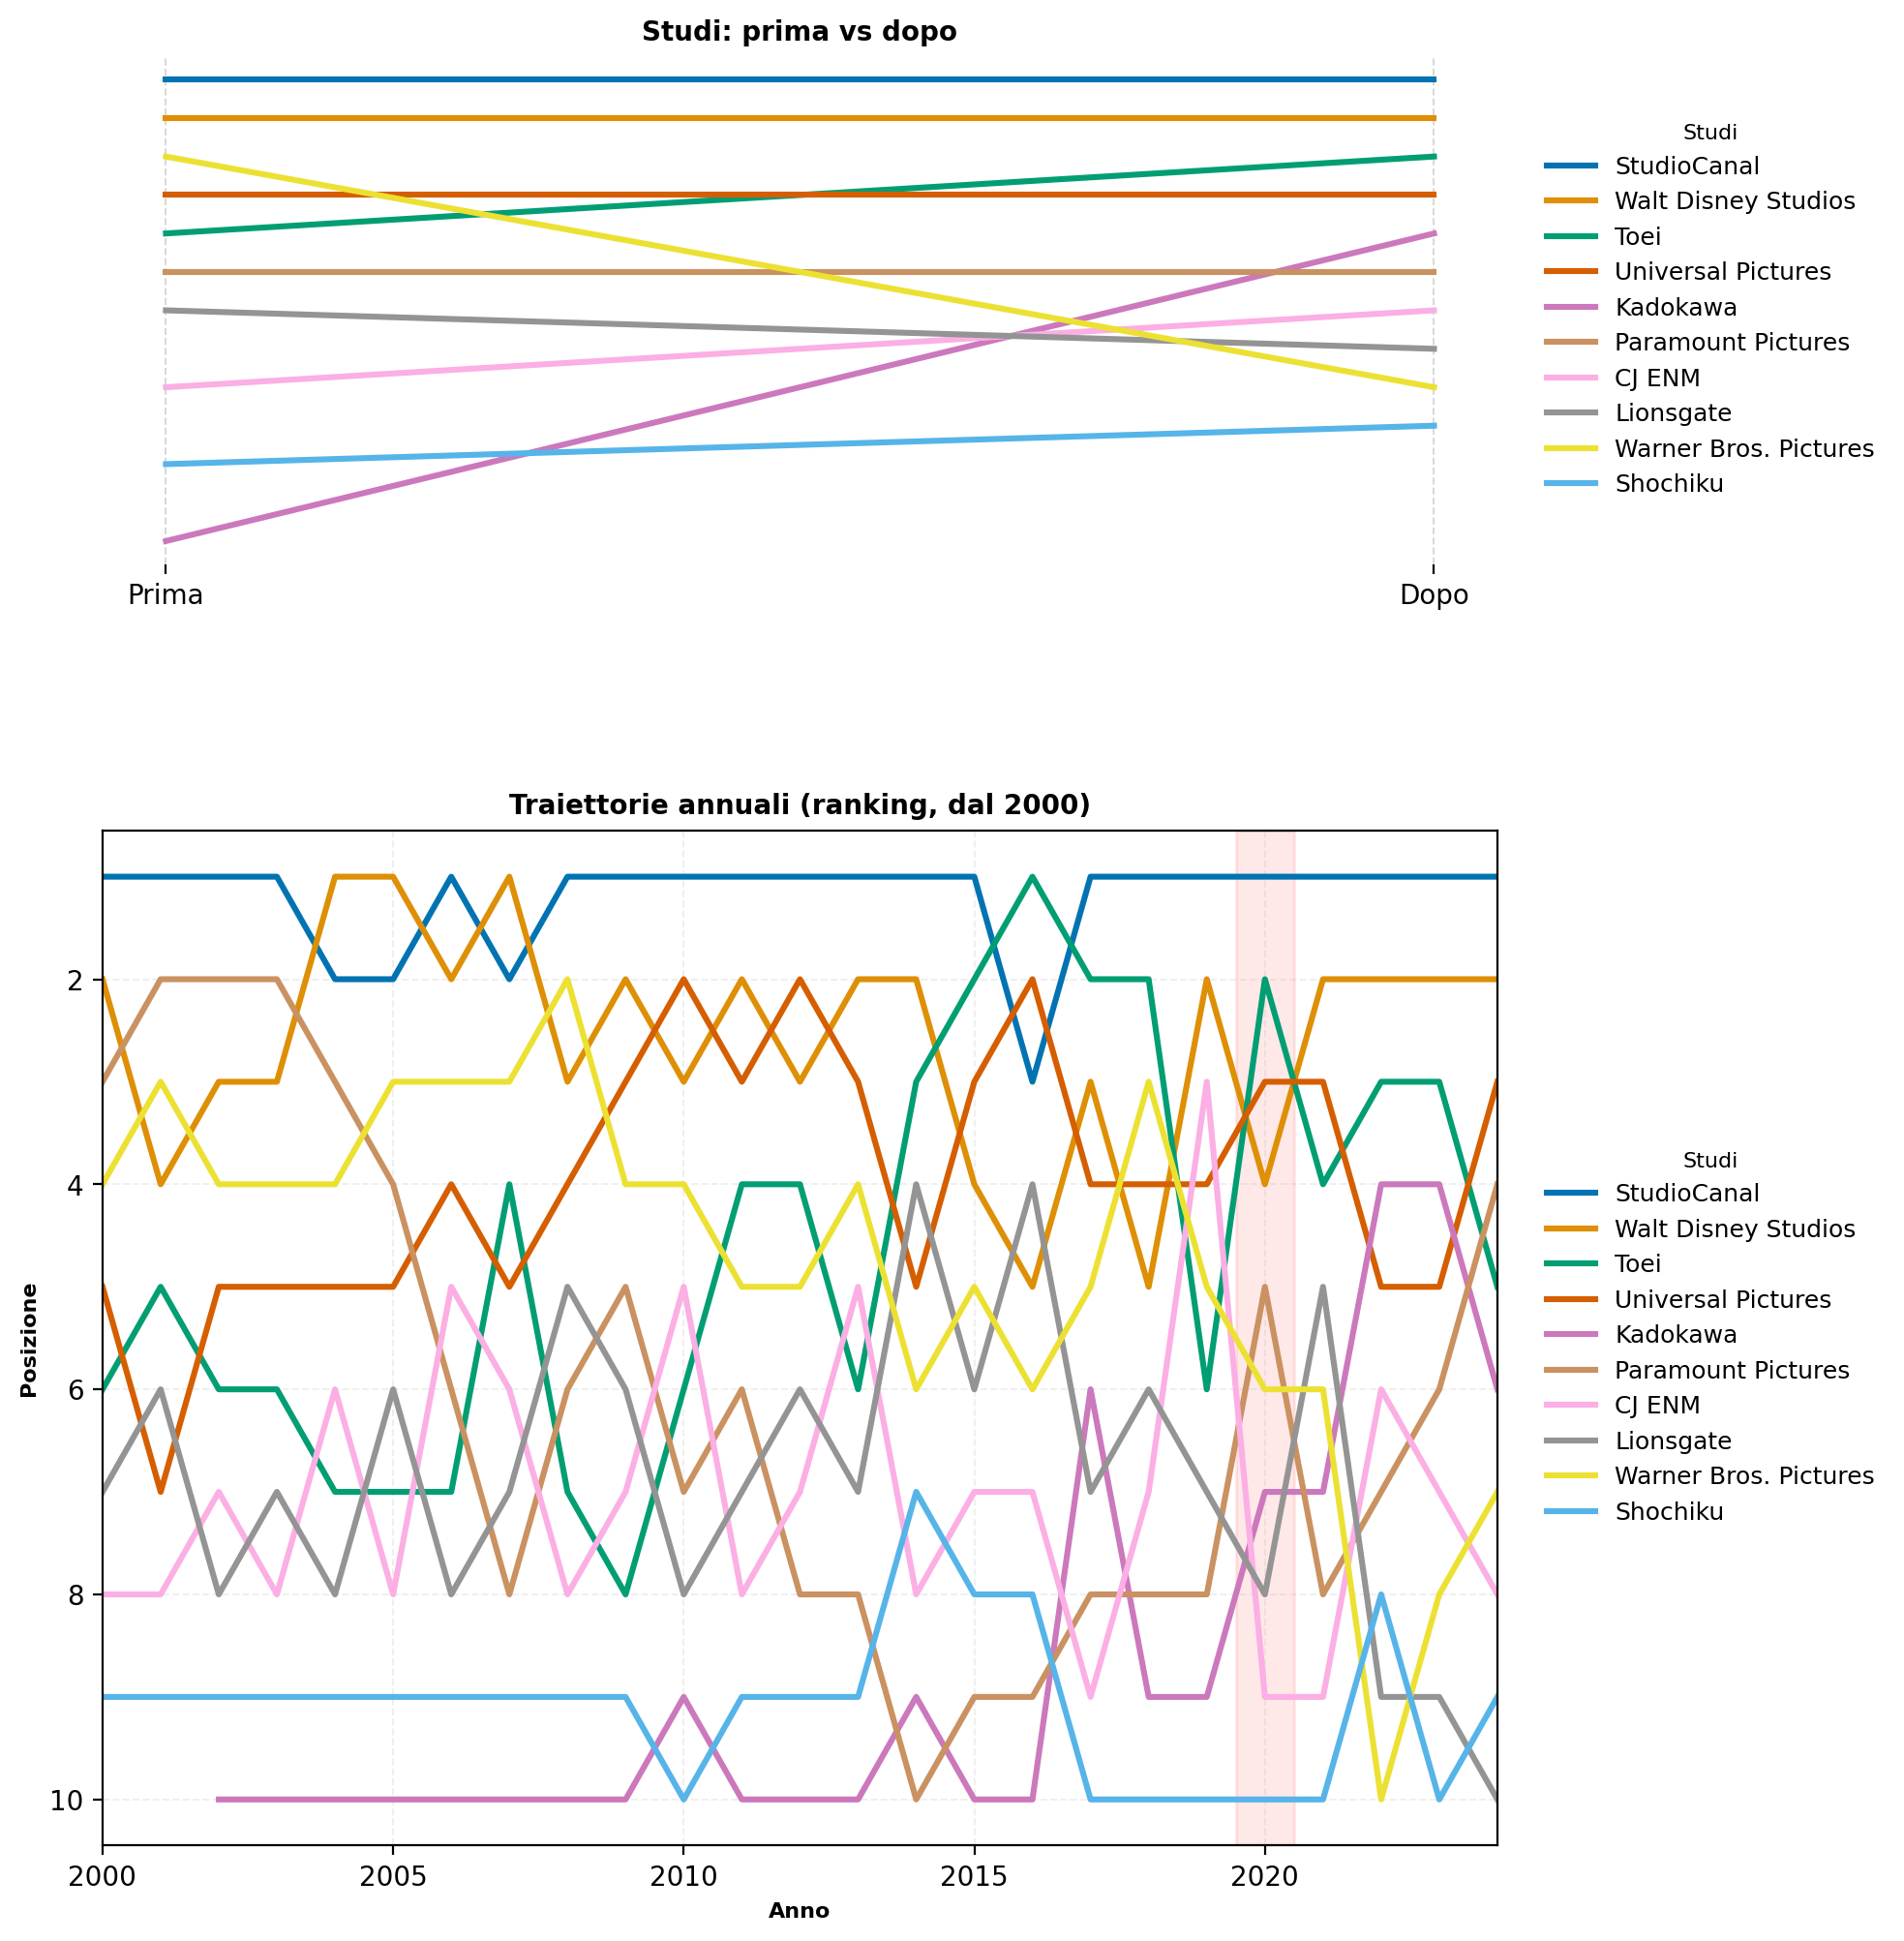

In [ ]:
palette_sel = sns.color_palette("colorblind", n_colors=min(10, len(studios)))
if len(studios) > len(palette_sel):
    palette_sel = sns.color_palette("tab20", len(studios))

color_map  = dict(zip(studios, palette_sel))

# layout in colonna: slopegraph sopra, bump chart sotto
fig = plt.figure(figsize=(11, 12))
spec = gridspec.GridSpec(2, 1, height_ratios=[1, 2], hspace=0.35)

# Slopegraph (sopra)
ax1 = fig.add_subplot(spec[0, 0])
for s in studios:
    ax1.plot([0, 1], [pre_rank[s], post_rank[s]], color=color_map[s], linewidth=2.2, alpha=1)
ax1.set_xticks([0, 1]); ax1.set_xticklabels(['Prima', 'Dopo'])
ax1.invert_yaxis(); ax1.set_yticks([]); ax1.set_title('Studi: prima vs dopo')
for side in ['top','right','left','bottom']: ax1.spines[side].set_visible(False)

# Bump chart (sotto)
ax2 = fig.add_subplot(spec[1, 0])
for s in studios:
    ax2.plot(ranks.index, ranks[s], color=color_map.get(s, 'red'), linewidth=2.2, alpha=1)
ax2.axvspan(2019.5, 2020.5, color='red', alpha=0.09)
ax2.invert_yaxis(); ax2.set_xlim(min_year, max_year); ax2.set_title(f'Traiettorie annuali (ranking, dal {min_year})')
ax2.set_xlabel('Anno'); ax2.set_ylabel('Posizione'); ax2.grid(True, alpha=.2)

legend_handles = [Line2D([0],[0], color=color_map[s], lw=2.2, label=s) for s in studios]
fig.subplots_adjust(right=0.78)

# legenda accanto allo slopegraph 
ax1.legend(
    handles=legend_handles,
    loc='center left', bbox_to_anchor=(1.02, 0.5),
    frameon=False, fontsize=9, ncol=1, title='Studi'
)
# legenda accanto al bump chart 
ax2.legend(
    handles=legend_handles,
    loc='center left', bbox_to_anchor=(1.02, 0.5),
    frameon=False, fontsize=9, ncol=1, title='Studi'
)

plt.show()

Si nota una rotazione della leadership con fasi di prevalenza limitate nel tempo. 

Un caso interessante è la salita di Toei attorno al 2016: è plausibile che intercetti il “momento” dell’animazione giapponese, sospinta da franchise consolidati, uscite evento in sala e una maggiore apertura dei mercati esteri. 
In quegli anni l’animazione beneficia di finestre più flessibili (cinema + home/streaming) e di una domanda globale in crescita, fattori che possono aver favorito i grandi player giapponesi rispetto al live action, più dipendente da set e logistica. 

La dinamica resta comunque competitiva: l’asse USA/EU mantiene continuità nelle posizioni alte, mentre i gruppi asiatici mostrano “onde” più marcate con ingressi in vetta e rientri. 

Dopo il 2020, il rimescolamento non ribalta le gerarchie ma evidenzia chi è riuscito ad adattarsi più rapidamente.

Abbiamo visto come cambiano i player nel tempo; verifichiamo ora se questo pattern trova riscontro nella geografia della produzione.
##### **Dove si concentra la produzione e come è cambiata nel tempo?**

### <span style="color: orange;"> *Produzione per Stato*

Per verificare se le traiettorie degli studi trovano riscontro nella geografia dell’industria, osserviamo come si distribuisce la produzione per Paese. 

Mettiamo in risalto i principali centri di produzione e la distribuzione sugli altri territori, mantenendo la stessa finestra temporale delle analisi precedenti e accorpando le co‑produzioni al Paese indicato come principale. 

La mappa offre una lettura immediata dei centri storici e delle aree in crescita; non è normalizzata per popolazione o mercato, quindi riflette la concentrazione industriale più che l’intensità pro capite.

In [32]:
geo_movie=pd.merge(df_finale['movies'],df_finale['countries'],on='id',how='inner')

start_year, end_year = 2000, 2024
exclude_years = {2020}

geo_movie = geo_movie[
    geo_movie['movie_year'].between(start_year, end_year) &
    ~geo_movie['movie_year'].isin(exclude_years)
]

In [33]:
from utils import name_to_iso3

film_per_paese = geo_movie["country"].value_counts().reset_index()
film_per_paese.columns = ["country", "num_films"]
film_per_paese["iso3"] = film_per_paese["country"].apply(name_to_iso3)
film_per_paese = film_per_paese.dropna(subset=["iso3"])
# scala logaritmica
film_per_paese["num_films"] = np.log(film_per_paese["num_films"])  

fig = px.choropleth(
  film_per_paese,
  locations="iso3",
  locationmode="ISO-3",
  color="num_films",
  title="Numero di Film Prodotti per Paese",
  color_continuous_scale="Oranges", 
  range_color=(film_per_paese["num_films"].min(), film_per_paese["num_films"].max()),  # Normalizzazione
  projection="natural earth",
)

fig.update_layout(
  geo=dict(
    showcoastlines=True,
    showland=True,
    landcolor="white",
    showocean=True,
    oceancolor="lightblue",
    showcountries=True,
    countrycolor="black",
  ),

  coloraxis=dict(
    colorbar=dict(
      title="Film Prodotti",  
      tickvals=np.log1p([1, 10, 100, 1000, 10000, 100000, 1000000]),  # Tick in scala logaritmica
      ticktext=["1", "10", "100", "1K", "10K", "100K", "1M"], 
    ),
    colorscale="Oranges",
    cmin=film_per_paese["num_films"].min(),  # Minimo valore log trasformato
    cmax=film_per_paese["num_films"].max(),  # Massimo valore log trasformato
    colorbar_tickmode="array",
  ),
  margin={"r": 0, "t": 40, "l": 0, "b": 0} 
)
film_per_paese['num_films'] = np.exp(film_per_paese['num_films'])
fig.show()

La mappa mostra dove si concentra la produzione. Per chiarire la gerarchia tra i Paesi, affianchiamo un grafico ordinato per volumi, così da leggere rapidamente chi guida e come si distribuisce il resto.

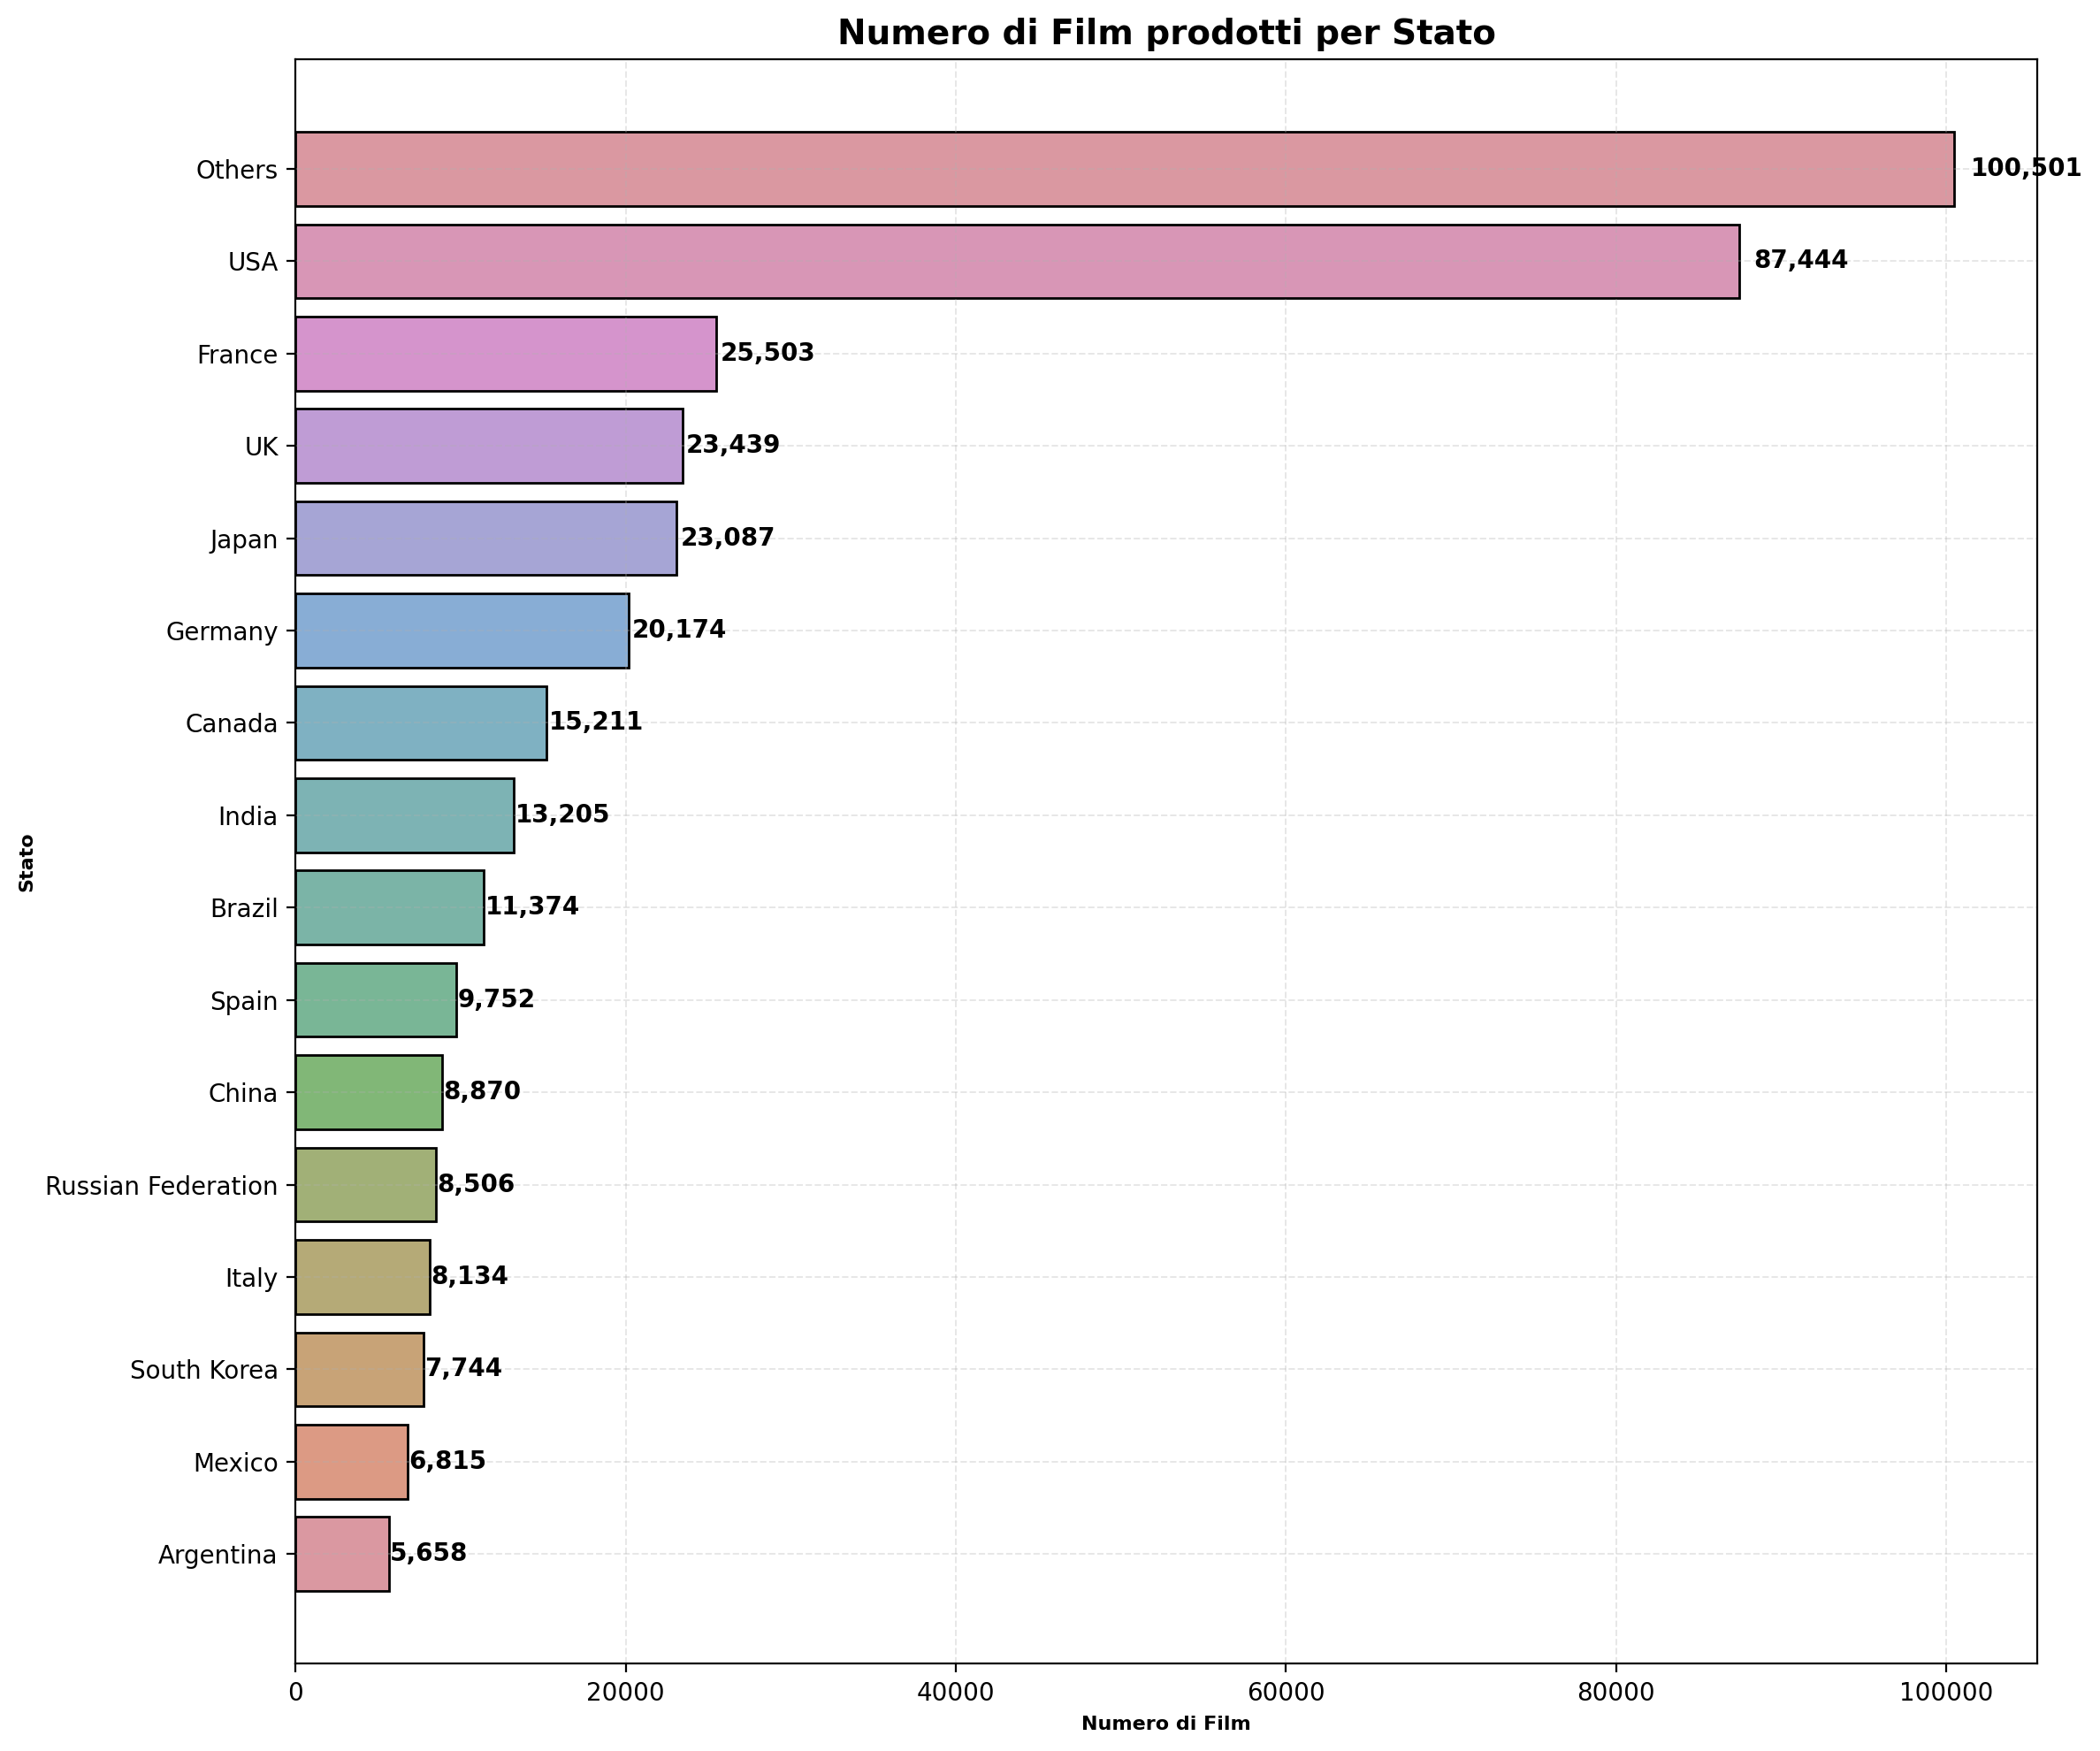

In [34]:
film_per_paese['country_15'] = None
film_per_paese.loc[0:14, 'country_15'] = film_per_paese.loc[0:14, 'country']
film_per_paese.loc[15:, 'country_15'] = 'Others'

film_per_paese_group = film_per_paese.groupby('country_15')['num_films'].sum()
film_per_paese_group = film_per_paese_group.sort_values()

pal = get_pastel_palette_light(n=15)

plt.figure(figsize=(12, 10))
bars = plt.barh(film_per_paese_group.index, film_per_paese_group.values, 
                edgecolor='black', linewidth=1, color=pal)

for i, bar in enumerate(bars):
    width = bar.get_width()
    plt.text(width + width*0.01, bar.get_y() + bar.get_height()/2, 
             f'{int(width):,}', ha='left', va='center', fontweight='bold')

plt.xlabel('Numero di Film')
plt.ylabel('Stato')
plt.title('Numero di Film prodotti per Stato', fontweight='bold', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Il grafico conferma la concentrazione su pochi Paesi, con un distacco visibile tra i primi e il resto. La graduatoria è coerente con la mappa, ma qui è più immediata da leggere.

Chiarito il quadro geografico della produzione, passiamo ai riconoscimenti.
##### **Come si distribuiscono candidature e vittorie rispetto a generi, durata ed epoche?**

### <span style="color: orange;">*Analisi degli Oscar*

Osserviamo come candidature e vittorie agli Oscar si distribuiscono per genere, durata ed epoche, e se questi andamenti dialogano con le dinamiche produttive emerse in precedenza. 

Usiamo il dataset dei candidati/premiati allineando anno del film e anno di cerimonia, trattando nomination e vittorie come misure distinte e armonizzando titoli e generi. 

L’obiettivo è leggere pattern ricorrenti più che stabilire causalità.

In [35]:
oscar_movie = pd.merge(df_finale['movies'],df_finale['the_oscar_awards'][~df_finale['the_oscar_awards']['movie_title'].isna()], on=['movie_title','movie_year'], how='inner')

In [36]:
nomination = oscar_movie.groupby('id').size()
win_losses_totali_film = oscar_movie.groupby('id')['winner'].value_counts().unstack(level=1)
vittorie_totali = win_losses_totali_film[True].fillna(0).astype(int)
oscar_movie['nomination'] = oscar_movie['id'].map(nomination)
oscar_movie['vittorie'] = oscar_movie['id'].map(vittorie_totali)
oscar_movie.drop_duplicates('id').sort_values(by='nomination',ascending=False)

,id,movie_title,movie_year,tagline,description,minute,movie_rating,categoria,year_ceremony,ceremony,category,member_name,winner,nomination,vittorie
325,1000074,Titanic,1997.0,Nothing on Earth could come between them.,101-year-old Rose DeWitt Bukater tells the sto...,194.0,3.81,lungo,1998,70,ACTRESS IN A LEADING ROLE,Kate Winslet,False,14,11
26,1000005,La La Land,2016.0,Here's to the fools who dream.,"Mia, an aspiring actress, serves lattes to mov...",129.0,4.09,lungo,2017,89,ACTOR IN A LEADING ROLE,Ryan Gosling,False,14,6
278,1000067,The Lord of the Rings: The Fellowship of the Ring,2001.0,One ring to rule them all,"Young hobbit Frodo Baggins, after inheriting a...",179.0,4.37,lungo,2002,74,ACTOR IN A SUPPORTING ROLE,Ian McKellen,False,13,4
3795,1004576,From Here to Eternity,1953.0,Pouring out of impassioned pages...brawling th...,"In 1941 Hawaii, a private is cruelly punished ...",118.0,3.76,lungo,1954,26,ACTOR,Montgomery Clift,False,13,8
747,1000258,The Shape of Water,2017.0,A Fairy Tale for Troubled Times,"An other-worldly story, set against the backdr...",123.0,3.67,lungo,2018,90,ACTOR IN A SUPPORTING ROLE,Richard Jenkins,False,13,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9013,1140821,D-Day Remembered,1994.0,NaN,An award-winning documentary of the invasion o...,54.0,NaN,medio,1995,67,DOCUMENTARY (Feature),Charles Guggenheim,False,1,0
9012,1135405,Saint Matthew Passion,1966.0,NaN,Oscar nominated documentary short from Hungary...,40.0,NaN,medio,1967,39,DOCUMENTARY (Short Subject),Mafilm Studio,False,1,0
9011,1134664,Breaking the Language Barrier,1961.0,NaN,The Air Force Thunderbirds present air shows f...,14.0,NaN,corto,1962,34,DOCUMENTARY (Short Subject),United States Air Force,False,1,0
9010,1134501,To Live Again,1963.0,NaN,To Live Again is a 1963 short documentary film...,20.0,NaN,corto,1964,36,DOCUMENTARY (Short Subject),"Mel London, Producer",False,1,0


I film con il maggior numero di nomination (Titanic con 14, Il Signore degli Anelli, La La Land) mostrano come l'Academy premi produzioni che combinano il successo commerciale, l'innovazione tecnica e un tipo di narrazione universale.


Analizziamo la correlazione tra il numero di vittorie di un film e le caratteristiche del suddetto:

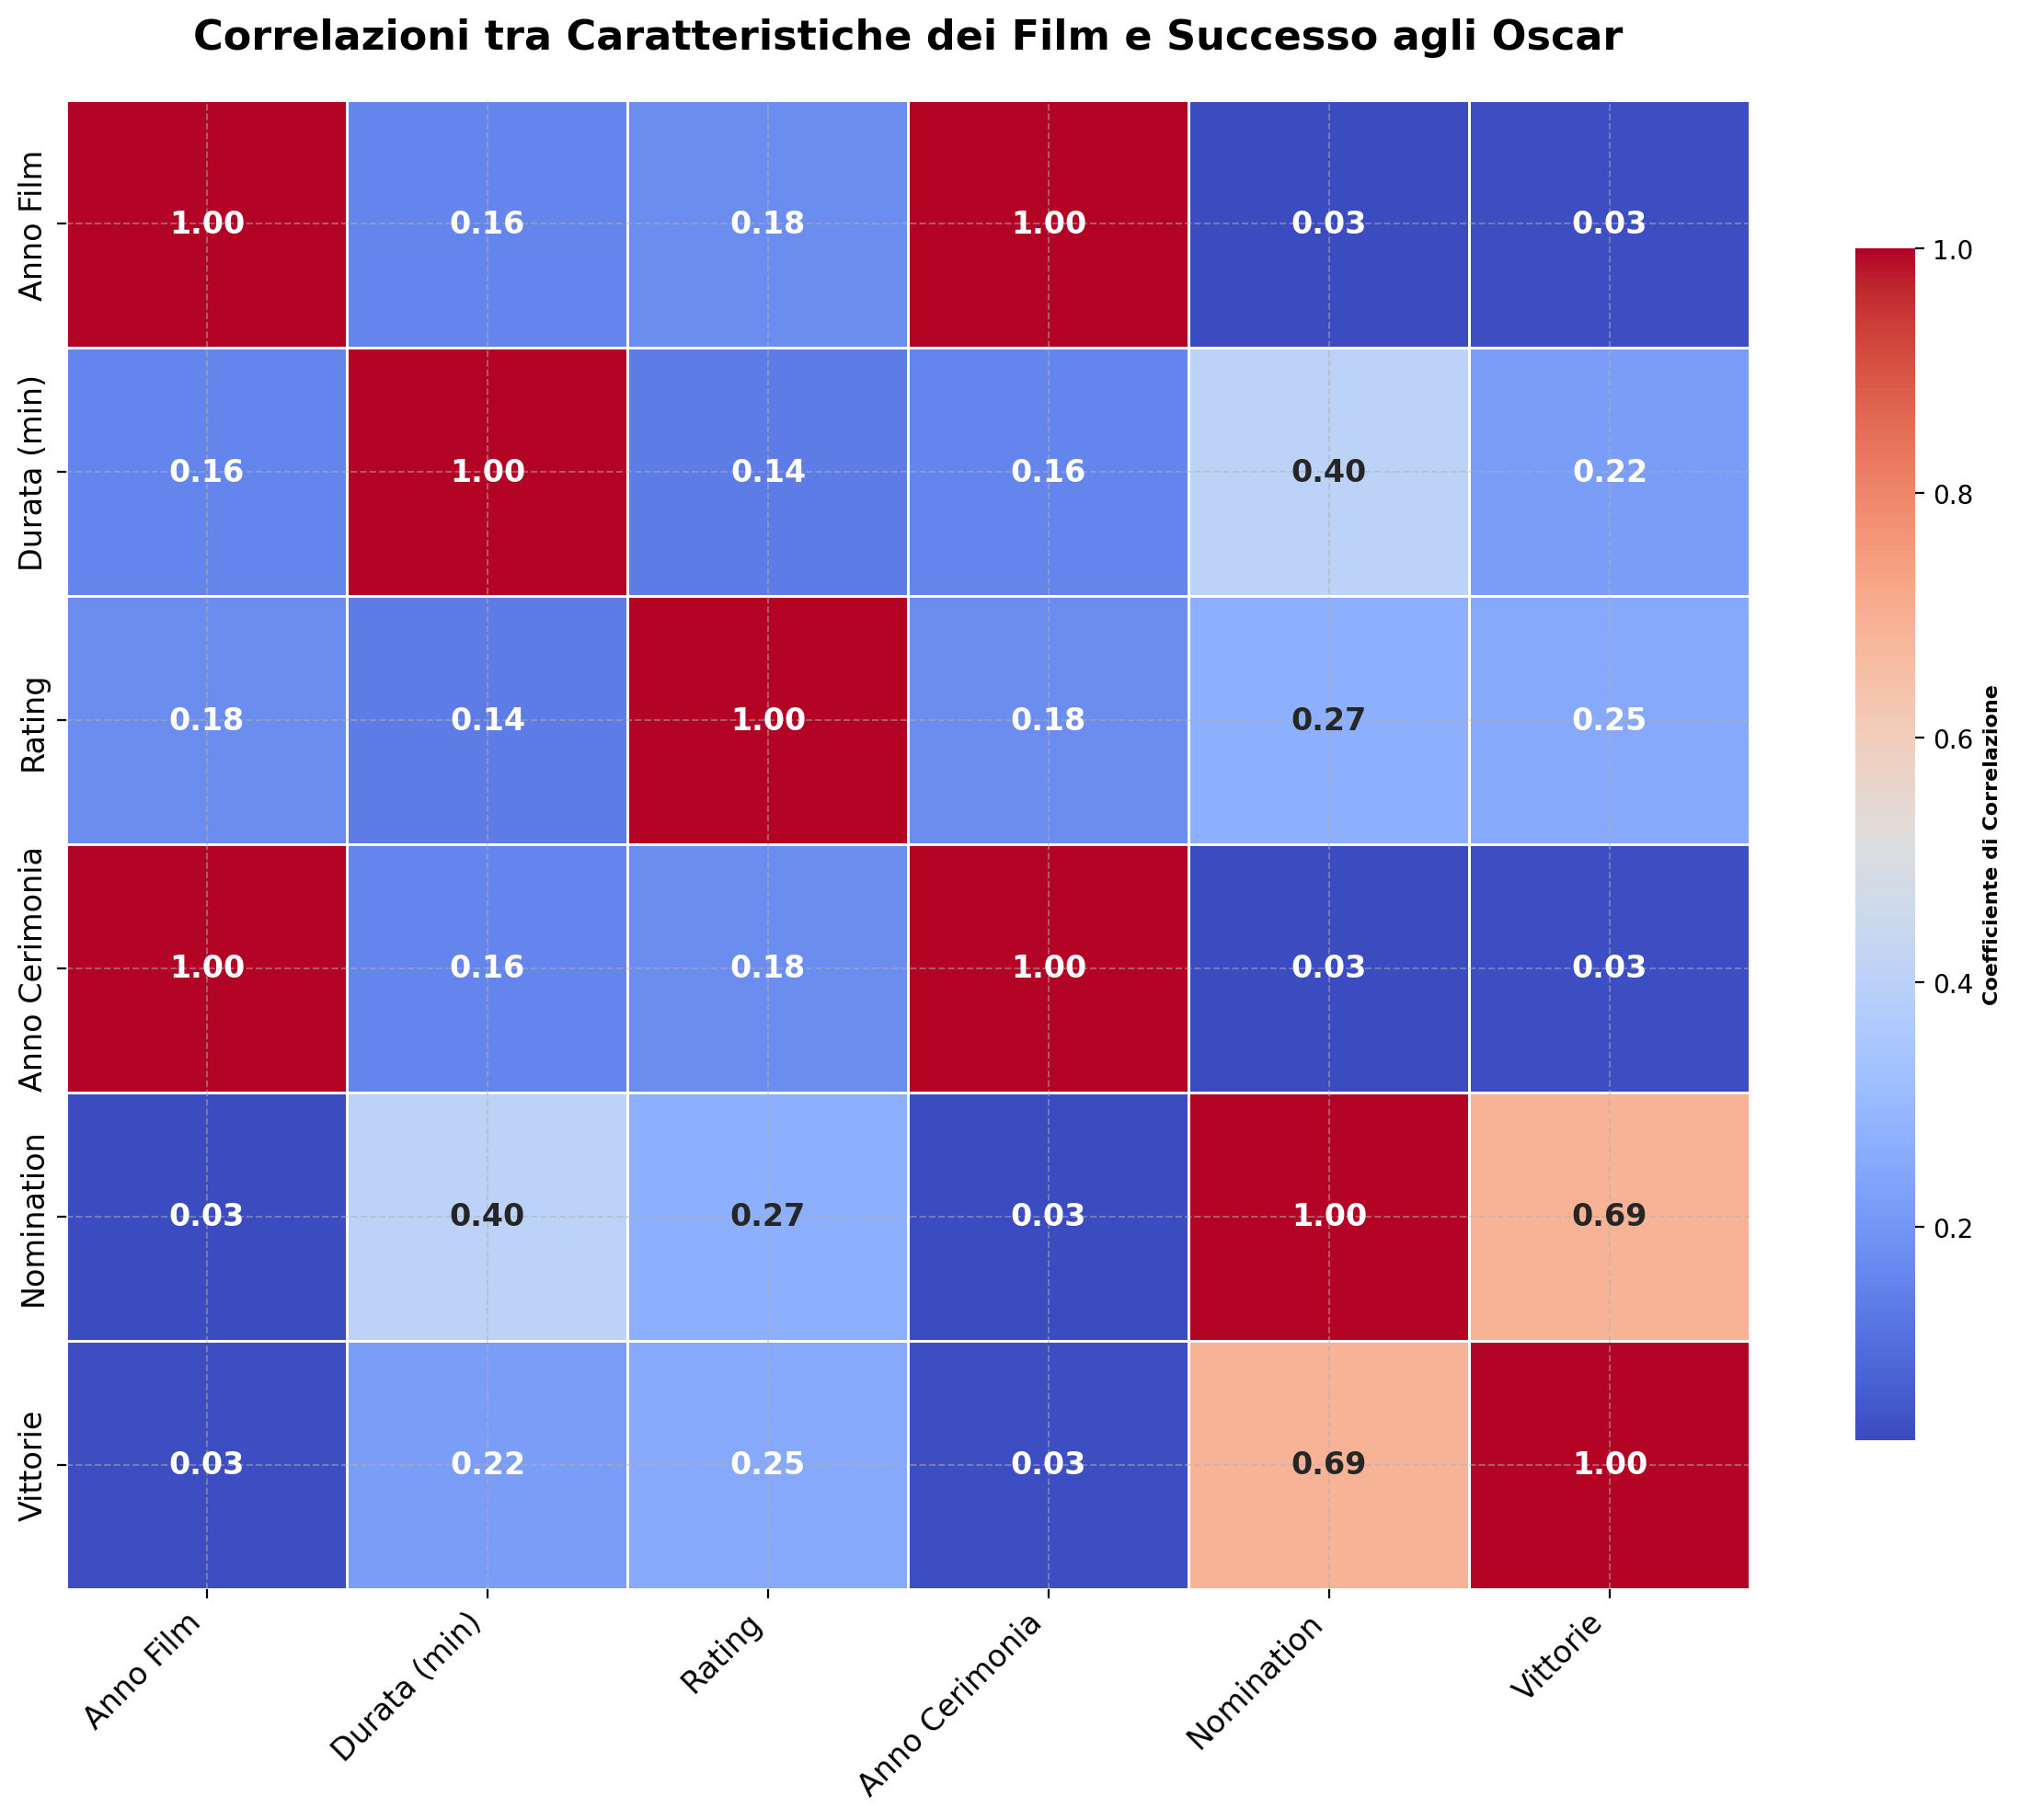

In [37]:
unique_movies = oscar_movie.drop_duplicates(subset='id')
numerical_columns = unique_movies[['movie_year', 'minute', 'movie_rating', 'year_ceremony', 'nomination','vittorie']]
correlations = numerical_columns.corr()

correlations_renamed = correlations.copy()
correlations_renamed.columns = ['Anno Film', 'Durata (min)', 'Rating', 'Anno Cerimonia', 'Nomination', 'Vittorie']
correlations_renamed.index = ['Anno Film', 'Durata (min)', 'Rating', 'Anno Cerimonia', 'Nomination', 'Vittorie']

plt.figure(figsize=(12, 10))
sns.heatmap(correlations_renamed, annot=True, cmap='coolwarm', fmt='.2f', 
            linewidths=0.5, cbar_kws={'shrink': 0.8, 'label': 'Coefficiente di Correlazione'},
            annot_kws={'size': 12, 'weight': 'bold'})
plt.title('Correlazioni tra Caratteristiche dei Film e Successo agli Oscar', 
          fontweight='bold', fontsize=16, pad=20)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

>Ricordiamo che i valori di correlazione vanno da -1 a +1. 
>- Valori vicini a +1 indicano una relazione positiva forte (quando una variabile cresce, anche l'altra tende a crescere).
>- Valori vicini a 0 indicano assenza di relazione lineare.

La correlazione più significativa che emerge è quella tra Nomination e Vittorie (0.69). Questo valore ci dice qualcosa di fondamentale sul funzionamento degli Oscar: più un film riceve nomination, maggiori sono le sue possibilità di vincere premi. Tuttavia, il fatto che la correlazione non sia perfetta (non è 1.00) indica che esistono altri fattori in gioco oltre al semplice numero di nomination.

Un risultato sorprendente è la correlazione tra Durata e Nomination (0.40). Questo pattern ci rivela un bias nel sistema degli Oscar: i film più lunghi tendono a ricevere più nomination. Questo fenomeno può essere interpretato in diversi modi, tra cui forse una percezione di "serietà artistica" e "complessità narrativa".

Un altro risultato interessante da analizzare è la correlazione sorprendentemente bassa tra Rating e il successo agli Oscar (0.27 con Nomination, 0.25 con Vittorie): questo rivela una disconnessione tra la qualità percepita dal pubblico e il riconoscimento accademico.

Vediamo invece correlazioni quasi nulle tra anno di produzione e successo (0.03).


Aggiungiamo adesso anche i generi all'analisi.

Approfondiamo i riconoscimenti per genere con due misure normalizzate: quanta ‘presenza agli Oscar’ c’è per 100 film prodotti e, tra i candidati, quale genere converte di più in vittorie. Questo riduce l’effetto volume e rende confrontabili generi molto diversi per produttività.

In [49]:
oscar_movie_genre = pd.merge(oscar_movie,df_finale['genres'],on='id',how='inner')

start_year, end_year = 2000, 2024
exclude_years = {2020}
min_film_per_genre = 200

movies_genres = (df_finale['genres'][['id','genre']]
                 .merge(df_finale['movies'][['id','movie_year']], on='id', how='inner'))
mg_win = movies_genres[
    movies_genres['movie_year'].between(start_year, end_year) &
    ~movies_genres['movie_year'].isin(exclude_years)
]
films_per_genre = mg_win.groupby('genre').size().rename('films_total')

omg = oscar_movie_genre[
    oscar_movie_genre['movie_year'].between(start_year, end_year) &
    ~oscar_movie_genre['movie_year'].isin(exclude_years)
].copy()

# Flag vincitore
if 'winner' in omg.columns:
    omg['is_winner'] = omg['winner'].astype(str).str.lower().isin(['true','1','yes','y'])
elif 'is_winner' in omg.columns:
    omg['is_winner'] = omg['is_winner'].astype(bool)
else:
    omg['is_winner'] = False

# Aggregazioni per genere
oscar_entries = omg.groupby('genre').size().rename('oscar_entries')
winners = omg.groupby('genre')['is_winner'].sum().rename('winners')

agg = (films_per_genre.to_frame()
       .join(oscar_entries, how='left')
       .join(winners, how='left')
       .fillna({'oscar_entries':0, 'winners':0}))

# Metriche normalizzate
agg['oscar_per_100'] = (agg['oscar_entries'] / agg['films_total']) * 100
agg['win_rate'] = (agg['winners'] / agg['oscar_entries']).replace([np.inf, np.nan], 0)

plot_df = agg[agg['films_total'] >= min_film_per_genre].sort_values('oscar_per_100', ascending=True)

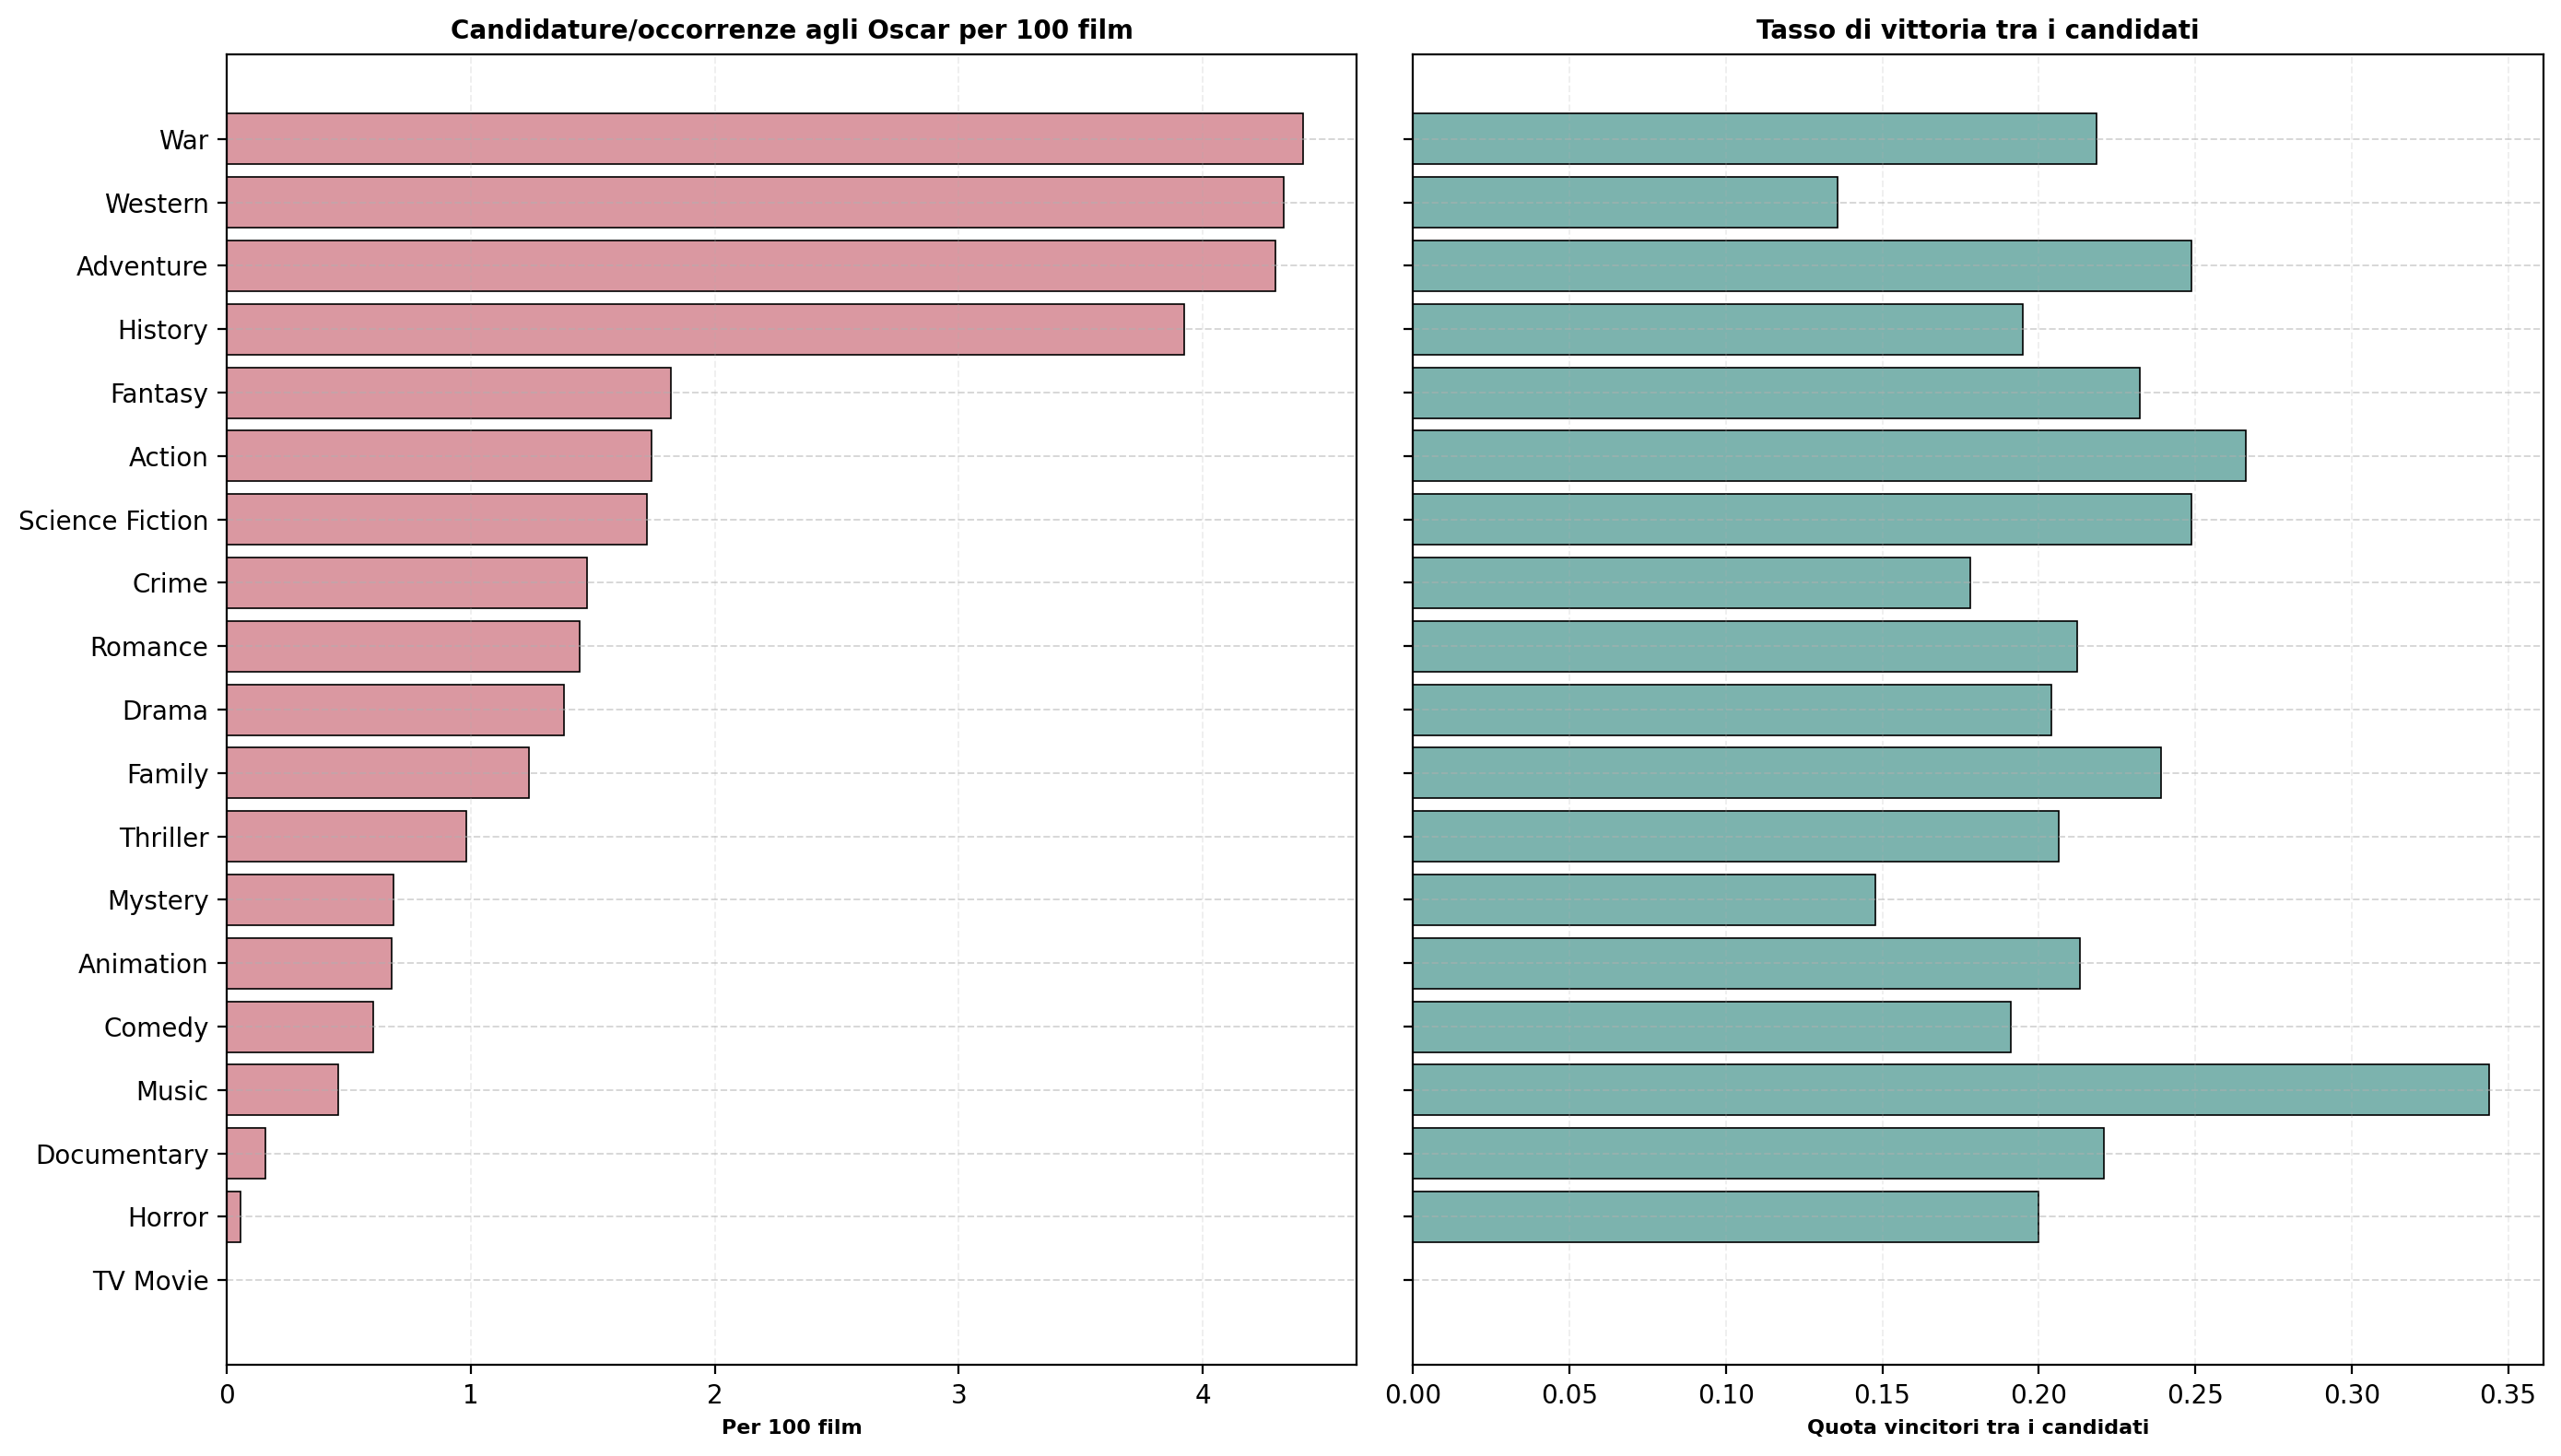

In [51]:
fig, axes = plt.subplots(1, 2, figsize=(14, 8), sharey=True)
palette = get_pastel_palette_light(n=2)

# Presenza agli Oscar per 100 film
axes[0].barh(plot_df.index, plot_df['oscar_per_100'], color=palette[0], edgecolor='black', linewidth=.6)
axes[0].set_title('Candidature/occorrenze agli Oscar per 100 film')
axes[0].set_xlabel('Per 100 film')

# Tasso di vittoria tra i candidati
plot_df2 = plot_df.sort_values('win_rate', ascending=True)
axes[1].barh(plot_df2.index, plot_df2['win_rate'], color=palette[1], edgecolor='black', linewidth=.6)
axes[1].set_title('Tasso di vittoria tra i candidati')
axes[1].set_xlabel('Quota vincitori tra i candidati')

for ax in axes:
    ax.grid(True, axis='x', alpha=.2)

plt.tight_layout()
plt.show()

Dai grafici emerge che visibilità e premi non coincidono. I generi con marcata identità tematica (war, western, adventure, history) compaiono più spesso tra i candidati, mentre horror, comedy, documentary e TV movie sono poco rappresentati. 

Sul piano delle vittorie, invece, spicca “music” (anche grazie all'esistenza di categorie dedicate) e si difendono action e avventura; il drama è molto presente ma non sempre efficace nel convertire candidature in premi, mentre western e mystery faticano. 

Le metriche sono normalizzate (presenza per 100 film e tasso di vittoria), ma il multi‑genere e i campioni piccoli possono influenzare le posizioni.

# <span style="color: skyblue;"> **Conclusioni**
Negli ultimi decenni la produzione generale cresce, si interrompe bruscamente intorno al 2020 a causa della crisi pandemica e riparte in modo diseguale: i formati più agili tornano prima, mentre i lungometraggi impiegano più tempo a riprendere il ritmo. 

Anche sul fronte dei produttori non c’è un dominatore stabile: la testa ruota tra pochi gruppi e le traiettorie mostrano sorpassi e rientri più che leadership durature. 

Geograficamente i volumi restano concentrati in pochi centri, con espansioni selettive in alcuni mercati; qui leggiamo quantità assolute, non intensità pro capite. 

Lato riconoscimenti, gli Oscar premiano logiche proprie: la durata, che può presupporre un intento di "serietà" e impegno, aiuta a essere candidati, ma non garantisce la vittoria; avere delle nominations non implica la vittoria. 
Tra i generi, quelli con identità narrativa marcata compaiono più spesso tra i candidati, mentre la conversione in vittorie è alta in “music” e buona in action/avventura; horror e commedia restano penalizzati.

In sintesi, emerge un ecosistema dinamico, influenzato dal progresso e da variabili esterne spesso non controllabili. Scelte di formato e specializzazioni industriali plasmano chi produce e cosa viene premiato, oltre la sola quantità.

## <span style="color: skyblue;"> Limiti dell'analisi

- **Copertura e qualità dei dati**: le fonti hanno formati e granularità diverse; mancano campi in alcuni dataset e la qualità informativa non è omogenea. I risultati dipendono dalla completezza e correttezza dei file disponibili.

- **Rilevazione dei duplicati**: l’individuazione dei duplicati nei dataset non‑movies si basa su normalizzazione (trim e lowercasing) e può marcare come duplicati record che differiscono per dettagli significativi; per `movies` la regola titolo+anno può non cogliere riedizioni, director’s cut o omonimie perfette.

- **Allineamento tra sorgenti eterogenee**: i join tra dataset (es. incrocio Oscar con `movie_title` e `movie_year`) sono sensibili a varianti nominali, traduzioni, alias e refusi. Questo può generare sia falsi negativi (match persi) sia falsi positivi (accoppiamenti errati).

- **Analisi prevalentemente descrittiva**: correlazioni, conteggi e confronti non implicano causalità.

- **Temporalità dei dati**: gli anni più recenti possono essere incompleti rispetto a uscite, premi e recensioni; i confronti temporali vanno quindi letti con cautela.